# Advent of code 2020

[[**Open the notebook in Colab**]](https://colab.research.google.com/github/hhoppe/advent_of_code/blob/main/2020/advent_of_code_2020.ipynb)

Jupyter [notebook](https://github.com/hhoppe/advent_of_code/blob/main/2020/advent_of_code_2020.ipynb)
by [Hugues Hoppe](http://hhoppe.com/) with Python solutions to the
[2020 Advent of Code puzzles](https://adventofcode.com/2020),
completed in December 2020.

I participated in the 25-day [Advent of Code](https://adventofcode.com/) for the first time this year, thanks to encouragement from colleagues, especially [Sascha Häberling](https://github.com/shaeberling).  It was great fun and provided a nice opportunity to learn more advanced Python.

In the event, many people compete to solve the puzzles as quickly as possible --- see the impressive times on the [leaderboard](https://adventofcode.com/2020/leaderboard).
My approach was much more casual, although I did aim to finish the puzzle each evening.

Later, I went back to explore more **polished and efficient solutions**.
Can the code be expressed more succinctly?
What is the fastest algorithm given the constraints of interpreted Python?
Along the way, I discovered the [`numba`](https://numba.pydata.org/) package which can JIT-compile bottleneck functions to native code;
is it practical for these problems?  Yes, it can help greatly!

This notebook is organized such that each day is self-contained and can be run on its own after the preamble.

Some **conclusions**:

- A Jupyter/IPython notebook is a great environment for exploration.
- The notebook conveniently bundles descriptions, notes, code, small test inputs, and results.
- Initially I stored puzzle inputs within the notebook itself, but this introduces clutter and runs inefficiently.
- The cloud-based CPU kernel/runtime provided by Colab works nicely.
- With the [`numba`](https://numba.pydata.org/) library (for days [11](#day11), [15](#day15), and [23](#day23)), all of this year's puzzles can be solved in 1 second or less.
- The total execution time across all 25 puzzles is about 4 s.

Here are some visualization results:

<p>
<a href="#day11">day11</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2020/results/day11a.gif" width="200">
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2020/results/day11b.gif" width="200">&emsp;
<a href="#day20">day20</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2020/results/day20a.png" width="200">
<img src="https://github.com/hhoppe/advent_of_code/raw/main/2020/results/day20b.png" width="200">
</p>
<p>
<a href="#day24">day24</a><img src="https://github.com/hhoppe/advent_of_code/raw/main/2020/results/day24.gif" width="200">
</p>

<a name="preamble"></a>
## Preamble

In [1]:
!command -v ffmpeg >/dev/null || (apt-get -qq update && apt-get -qq -y install ffmpeg) >/dev/null

In [2]:
!pip install -q advent-of-code-hhoppe hhoppe-tools mediapy more-itertools numba

In [40]:
from __future__ import annotations

import bisect
import collections
from collections.abc import Iterable
import functools
import itertools
import math
import operator
import re
import sys
import textwrap
import types
from typing import Any

import advent_of_code_hhoppe  # https://github.com/hhoppe/advent-of-code-hhoppe/blob/main/advent_of_code_hhoppe/__init__.py
import hhoppe_tools as hh  # https://github.com/hhoppe/hhoppe-tools/blob/main/hhoppe_tools/__init__.py
import matplotlib
import matplotlib.pyplot as plt
import mediapy as media
import more_itertools
import numpy as np

In [4]:
if not media.video_is_available():
  media.show_videos = lambda *a, **kw: print('Creating video is unavailable.')

In [5]:
hh.start_timing_notebook_cells()

In [6]:
YEAR = 2020

In [7]:
# (1) To obtain puzzle inputs and answers, we first try these paths/URLs:
PROFILE = 'google.Hugues_Hoppe.965276'
# PROFILE = 'github.hhoppe.1452460'
TAR_URL = f'https://github.com/hhoppe/advent_of_code/raw/main/{YEAR}/data/{PROFILE}.tar.gz'
if 1:
  hh.run(
      f'if [ ! -d data/{PROFILE} ]; then (mkdir -p data && cd data &&'
      f' wget -q {TAR_URL} && tar xzf {PROFILE}.tar.gz); fi'
  )
INPUT_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}_input.txt'
ANSWER_URL = f'data/{PROFILE}/{{year}}_{{day:02d}}{{part_letter}}_answer.txt'

In [8]:
# (2) If URL is not found, we may try adventofcode.com using a session cookie:
if 0:
  # !rm -f ~/.config/aocd/token*; mkdir -p ~/.config/aocd; echo 53616... >~/.config/aocd/token
  # where "53616..." is the session cookie from "adventofcode.com" (valid 1 month).
  hh.run('pip install -q advent-of-code-data')  # https://github.com/wimglenn/advent-of-code-data
  import aocd  # pylint: disable=unused-import # noqa

In [9]:
try:
  import numba
except ModuleNotFoundError:
  print('Package numba is unavailable.')
  numba = sys.modules['numba'] = types.ModuleType('numba')
  numba.njit = hh.noop_decorator
using_numba = hasattr(numba, 'jit')

In [10]:
advent = advent_of_code_hhoppe.Advent(year=YEAR, input_url=INPUT_URL, answer_url=ANSWER_URL)

In [11]:
hh.adjust_jupyterlab_markdown_width()

### Helper functions

In [12]:
check_eq = hh.check_eq
_ORIGINAL_GLOBALS = list(globals())

<a name="day1"></a>
## Day 1: Find summing numbers

- Part 1: Given a list of numbers, find two entries that sum to 2020 and multiply those entries together.

- Part 2: Find three entries that sum to 2020 and multiply those entries together.

In [15]:
puzzle = advent.puzzle(day=1)

For [day 1](https://adventofcode.com/2020/day/1), `puzzle.input` has 200 lines:

1686
1983
1801
1890
1910
1722
1571
1952
 ...
1261
1154
1769
1529


The stored answers are: `{1: '651651', 2: '214486272'}`

In [16]:
# A test input provided in the puzzle description:
s1 = """\
1721
979
366
299
675
1456
"""

In [17]:
def day1(s, *, total=2020):
  entries = set(map(int, s.split()))
  for a in entries:
    b = total - a
    if b in entries:
      return a * b
  return None


check_eq(day1(s1), 514579)  # Reference answer provided in the description.
puzzle.verify(1, day1)  # ~0 ms.

(Part 1: 0.000 s)


In [18]:
def day1_part2(s, *, total=2020):
  entries = set(map(int, s.split()))
  for a in entries:
    for b in entries:
      c = total - a - b
      if c in entries:
        return a * b * c
  return None


check_eq(day1_part2(s1), 241861950)
puzzle.verify(2, day1_part2)  # ~1 ms.

(Part 2: 0.001 s)


<a name="day2"></a>
## Day 2: Valid passwords

Given input lines each containing a password rule (`i-j c`) and a password, count the number of "valid" passwords such that:

- Part 1: The number of instances of character `c` in the password is in the range `[i, j]`.

- Part 2: The password characters at positions `i` and `j` contain exactly one instance of character `c`.

In [19]:
puzzle = advent.puzzle(day=2)

For [day 2](https://adventofcode.com/2020/day/2), `puzzle.input` has 1_000 lines:

4-7 z: zzzfzlzzz
3-4 l: blllk
8-11 j: jjjjjjjgjjjj
6-7 l: lllhlbl
10-13 x: xmhfsbjxptxxv
2-3 s: ssvxszrvj
4-6 r: rtrrrqv
5-6 c: cbccxc
 ...
9-10 w: wwwwwwbwwhww
5-6 g: kgggjg
4-8 s: ssssssscs
12-20 t: ttttttltttvttttttttt


The stored answers are: `{1: '396', 2: '428'}`

In [20]:
s1 = """\
1-3 a: abcde
1-3 b: cdefg
2-9 c: ccccccccc
"""

In [21]:
def day2(s, *, part2=False):
  lines = s.splitlines()
  num_valid = 0
  for line in lines:
    vmin0, vmax0, ch, password = hh.re_groups(r'^(\d+)-(\d+) (\w): (\w+)$', line)
    vmin, vmax = int(vmin0), int(vmax0)
    if part2:
      num_valid += (password[vmin - 1] == ch) ^ (password[vmax - 1] == ch)
    else:
      num_valid += vmin <= sum(c == ch for c in password) <= vmax
  return num_valid


check_eq(day2(s1), 2)
puzzle.verify(1, day2)  # ~3 ms.

day2_part2 = functools.partial(day2, part2=True)
check_eq(day2_part2(s1), 1)
puzzle.verify(2, day2_part2)  # ~1 ms.

(Part 1: 0.002 s)
(Part 2: 0.001 s)


<a name="day3"></a>
## Day 3: Count intersections in grid

Given a 2D grid containing sparse "trees", determine the number of trees encountered when moving from the top-left to the bottom row with a slope `(dy, dx)` and using wraparound addressing on the horizontal axis.

- Part 1: Count the trees for the slope `(dy, dx) = (1, 3)`

- Part 2: Compute the product of the tree counts for slopes `(1, 1)`, `(1, 3)`, `(1, 5)`, `(1, 7)`, and `(2, 1)`.

In [22]:
puzzle = advent.puzzle(day=3)

For [day 3](https://adventofcode.com/2020/day/3), `puzzle.input` has 323 lines:

........#.............#........
...#....#...#....#.............
.#..#...#............#.....#..#
..#......#..##............###..
..........#......#..#..#.......
.#..#.......#.........#.#......
.........#..#....##..#.##....#.
..#....##...#..................
 ...
..................#...#....#.##
......#.#....#.................
......#.#.....#.....#..##......
#..##...........#..#.....#.##..


The stored answers are: `{1: '148', 2: '727923200'}`

In [23]:
s1 = """\
..##.......
#...#...#..
.#....#..#.
..#.#...#.#
.#...##..#.
..#.##.....
.#.#.#....#
.#........#
#.##...#...
#...##....#
.#..#...#.#
"""

In [24]:
def day3a(s, *, part2=False):  # Slower.
  dyxs = ((1, 1), (1, 3), (1, 5), (1, 7), (2, 1)) if part2 else ((1, 3),)
  grid = np.array(list(map(list, s.splitlines())))

  def get_count(dy, dx):
    y, x = 0, 0
    count = 0
    while y < grid.shape[0]:
      count += grid[y, x] == '#'
      y, x = y + dy, (x + dx) % grid.shape[1]
    return count

  return math.prod(get_count(dy, dx) for dy, dx in dyxs)


check_eq(day3a(s1), 7)
puzzle.verify(1, day3a)  # ~1 ms.

day3a_part2 = functools.partial(day3a, part2=True)
check_eq(day3a_part2(s1), 336)
puzzle.verify(2, day3a_part2)  # ~3 ms.

(Part 1: 0.001 s)
(Part 2: 0.001 s)


In [25]:
def day3(s, *, part2=False):  # Faster.
  dyxs = ((1, 1), (1, 3), (1, 5), (1, 7), (2, 1)) if part2 else ((1, 3),)
  grid = hh.grid_from_string(s)

  def get_count(dy, dx):
    y = np.arange(0, grid.shape[0], dy)
    x = (np.arange(len(y)) * dx) % grid.shape[1]
    return np.count_nonzero(grid[y, x] == '#')

  return math.prod(get_count(dy, dx) for dy, dx in dyxs)


check_eq(day3(s1), 7)
puzzle.verify(1, day3)  # ~1 ms.

day3_part2 = functools.partial(day3, part2=True)
check_eq(day3_part2(s1), 336)
puzzle.verify(2, day3_part2)  # ~2 ms.

(Part 1: 0.001 s)
(Part 2: 0.001 s)


<a name="day4"></a>
## Day 4: Valid text fields

Given records containing various fields, count the number of valid records.

- Part 1: Each record is valid if it contains at least some required fields.

- Part 2: The fields also satisfy a set of requirements.

In [26]:
puzzle = advent.puzzle(day=4)

For [day 4](https://adventofcode.com/2020/day/4), `puzzle.input` has 1_102 lines:

hcl:5d90f0 cid:270 ecl:#66dc9c hgt:62cm byr:1945 pid:63201172 eyr:2026

ecl:amb byr:1943 iyr:2014 eyr:2028
pid:333051831

byr:1971
eyr:2021 iyr:2015 pid:158388040 hcl:#18171d ecl:brn hgt:179cm

 ...
hcl:#7d3b0c pid:431742871
ecl:hzl hgt:169cm cid:340
eyr:2023
iyr:2017 byr:1994


The stored answers are: `{1: '216', 2: '150'}`

In [27]:
# spellcheck=off
s1 = """\
ecl:gry pid:860033327 eyr:2020 hcl:#fffffd
byr:1937 iyr:2017 cid:147 hgt:183cm

iyr:2013 ecl:amb cid:350 eyr:2023 pid:028048884
hcl:#cfa07d byr:1929

hcl:#ae17e1 iyr:2013
eyr:2024
ecl:brn pid:760753108 byr:1931
hgt:179cm

hcl:#cfa07d eyr:2025 pid:166559648
iyr:2011 ecl:brn hgt:59in
"""

# all invalid
s2 = """\
eyr:1972 cid:100
hcl:#18171d ecl:amb hgt:170 pid:186cm iyr:2018 byr:1926

iyr:2019
hcl:#602927 eyr:1967 hgt:170cm
ecl:grn pid:012533040 byr:1946

hcl:dab227 iyr:2012
ecl:brn hgt:182cm pid:021572410 eyr:2020 byr:1992 cid:277

hgt:59cm ecl:zzz
eyr:2038 hcl:74454a iyr:2023
pid:3556412378 byr:2007
"""

# all valid
s3 = """\
pid:087499704 hgt:74in ecl:grn iyr:2012 eyr:2030 byr:1980
hcl:#623a2f

eyr:2029 ecl:blu cid:129 byr:1989
iyr:2014 pid:896056539 hcl:#a97842 hgt:165cm

hcl:#888785
hgt:164cm byr:2001 iyr:2015 cid:88
pid:545766238 ecl:hzl
eyr:2022

iyr:2010 hgt:158cm hcl:#b6652a ecl:blu byr:1944 eyr:2021 pid:093154719
"""
# spellcheck=on

In [28]:
# Field requirements:
# byr (Birth Year) - four digits; at least 1920 and at most 2002.
# iyr (Issue Year) - four digits; at least 2010 and at most 2020.
# eyr (Expiration Year) - four digits; at least 2020 and at most 2030.
# hgt (Height) - a number followed by either cm or in:
# If cm, the number must be at least 150 and at most 193.
# If in, the number must be at least 59 and at most 76.
# hcl (Hair Color) - a # followed by exactly six characters 0-9 or a-f.
# ecl (Eye Color) - exactly one of: amb blu brn gry grn hzl oth.
# pid (Passport ID) - a nine-digit number, including leading zeroes.
# cid (Country ID) - ignored, missing or not.

In [29]:
def day4(s, *, part2=False):
  passports = s.split('\n\n')

  def part1_valid(fields):
    required_fields = set('byr iyr eyr hgt hcl ecl pid'.split())
    return all(field in fields for field in required_fields)

  def year(field):
    return int(hh.re_groups(r'^(\d{4})$', fields[field])[0])

  def part2_valid(fields):
    try:
      value, unit = hh.re_groups(r'^(\d+)(cm|in)$', fields['hgt'])
      return bool(
          1920 <= year('byr') <= 2002  # pylint: disable=chained-comparison
          and 2010 <= year('iyr') <= 2020
          and 2020 <= year('eyr') <= 2030
          and (unit != 'cm' or 150 <= int(value) <= 193)
          and (unit != 'in' or 59 <= int(value) <= 76)
          and re.fullmatch(r'#[0-9a-f]{6}', fields['hcl'])
          and fields['ecl'] in 'amb blu brn gry grn hzl oth'.split()
          and re.fullmatch(r'[0-9]{9}', fields['pid'])
      )
    except (KeyError, ValueError):
      return False

  num_valid = 0
  for passport in passports:
    fields: dict[str, str] = dict(
        hh.re_groups(r'^(\w\w\w):(\S+)$', s_field)  # type: ignore[misc]
        for s_field in passport.split()
    )
    num_valid += part2_valid(fields) if part2 else part1_valid(fields)

  return num_valid


check_eq(day4(s1), 2)
puzzle.verify(1, day4)  # ~3 ms.

day4_part2 = functools.partial(day4, part2=True)
check_eq(day4_part2(s2), 0)  # all records are invalid
check_eq(day4_part2(s3), 4)  # all records are valid
puzzle.verify(2, day4_part2)  # ~6 ms.

(Part 1: 0.002 s)
(Part 2: 0.002 s)


<a name="day5"></a>
## Day 5: Free seat in grid

Given input lines, each specifying a seat identified using a binary encoding with symbols **B**ack, **F**ront, **L**eft, **R**ight.

- Part 1: Determine the maximum seat id.

- Part 2: Determine the missing seat id in the middle of the bunch.

In [30]:
puzzle = advent.puzzle(day=5)

For [day 5](https://adventofcode.com/2020/day/5), `puzzle.input` has 897 lines:

BFBBFFBRRL
BFBFFFFRLL
FBFBFFBRRR
FFBBBFBRLL
BBBFBFBRLR
BFBBFBFLRR
FBBBFFFRRL
BBFFBFFLLL
 ...
BBFBFBFRRL
BFFBBBBLLL
FBFFBFBRRR
FBFFFFBRLR


The stored answers are: `{1: '965', 2: '524'}`

In [31]:
# spellcheck=off
def day5_seat_id(line):
  return int(line.translate(str.maketrans('FBLR', '0101')), base=2)


check_eq(day5_seat_id('FBFBBFFRLR'), 357)
check_eq(day5_seat_id('BFFFBBFRRR'), 567)
check_eq(day5_seat_id('FFFBBBFRRR'), 119)
check_eq(day5_seat_id('BBFFBBFRLL'), 820)
# spellcheck=on


def day5(s):
  return max(day5_seat_id(line) for line in s.split())


puzzle.verify(1, day5)  # ~1 ms.

(Part 1: 0.000 s)


Part 2

In [32]:
def day5_visualize_transposed_seat_grid(s):
  grid = np.full((128, 8), 0)
  yx = np.array([divmod(day5_seat_id(line), 8) for line in s.split()])
  grid[tuple(yx.T)] = 1
  if 0:
    print('\n'.join(''.join('.#'[e] for e in row) for row in grid.T))
  media.show_image(grid.T == 1, border=True, width=600)


day5_visualize_transposed_seat_grid(puzzle.input)

""


In [33]:
def day5a_part2(s):  # Using regular expression search.
  seat_ids = [day5_seat_id(line) for line in s.split()]
  occupied = ''.join('01'[seat_id in seat_ids] for seat_id in range(128 * 8))
  (seat_id,) = [match.start() for match in re.finditer('(?<=1)0(?=1)', occupied)]
  return seat_id


puzzle.verify(2, day5a_part2)  # ~11 ms.

(Part 2: 0.002 s)


In [34]:
def day5b_part2(s):  # Using string indexing.
  def find_all(string, substring, overlapping=False):
    i = string.find(substring)
    while i != -1:
      yield i
      i = string.find(substring, i + (1 if overlapping else len(substring)))

  seat_ids = [day5_seat_id(line) for line in s.split()]
  occupied = ''.join('01'[seat_id in seat_ids] for seat_id in range(128 * 8))
  (i,) = list(find_all(occupied, '101'))
  seat_id = i + 1
  return seat_id


puzzle.verify(2, day5b_part2)  # ~9 ms.

(Part 2: 0.002 s)


In [35]:
def day5c_part2(s):  # Fast, using numpy successive differences of sorted indices.
  seat_ids = np.sort([day5_seat_id(line) for line in s.split()])
  diff = np.diff(seat_ids)
  ((i,),) = np.nonzero(diff == 2)
  seat_id = seat_ids[i] + 1
  return seat_id


puzzle.verify(2, day5c_part2)  # ~2 ms.

(Part 2: 0.001 s)


In [36]:
def day5_part2(s):  # Also fast, using numpy subsequence search.
  def matching_subsequences(array, sequence):
    array, sequence = np.asarray(array), np.asarray(sequence)
    return (
        array[np.arange(len(array) - len(sequence) + 1)[:, None] + np.arange(len(sequence))]
        == sequence
    ).all(axis=1)

  seat_ids = [day5_seat_id(line) for line in s.split()]
  occupied = np.full(128 * 8, False)
  occupied[seat_ids] = True
  ((i,),) = matching_subsequences(occupied, (1, 0, 1)).nonzero()
  seat_id = i + 1
  return seat_id


puzzle.verify(2, day5_part2)  # ~2 ms.

(Part 2: 0.001 s)


<a name="day6"></a>
## Day 6: Counts across groups

Given a set of records of words:

- Part 1: Compute the number of unique letters in each record, and sum these.

- Part 2: Compute the number of letters appearing in all words of each record, and sum these.

In [37]:
puzzle = advent.puzzle(day=6)

For [day 6](https://adventofcode.com/2020/day/6), `puzzle.input` has 2_172 lines:

su
egu

h
h
h
h

 ...

lfhtzrxcj
fbtzlhrcj
lzdaftrjphco


The stored answers are: `{1: '6590', 2: '3288'}`

In [38]:
s1 = """\
abc

a
b
c

ab
ac

a
a
a
a

b
"""

Part 1

In [39]:
def day6a_part1(s):  # Long code.
  total = 0
  for group in s.split('\n\n'):
    union = set()
    for line in group.splitlines():
      union |= set(line)
    total += len(union)
  return total


check_eq(day6a_part1(s1), 11)
puzzle.verify(1, day6a_part1)  # ~3 ms.

(Part 1: 0.001 s)


In [40]:
def day6b_part1(s):  # Using reduction.
  return sum(
      len(functools.reduce(operator.or_, map(set, group.splitlines()))) for group in s.split('\n\n')
  )


check_eq(day6b_part1(s1), 11)
puzzle.verify(1, day6b_part1)  # ~3 ms.

(Part 1: 0.001 s)


In [41]:
def day6_part1(s):  # Compact, and also fastest.
  return sum(len(set(group.replace('\n', ''))) for group in s.split('\n\n'))


check_eq(day6_part1(s1), 11)
puzzle.verify(1, day6_part1)  # ~1 ms.

(Part 1: 0.000 s)


Part 2

In [42]:
def day6a_part2(s):  # Using reduction.
  return sum(
      len(functools.reduce(operator.and_, map(set, group.splitlines())))
      for group in s.split('\n\n')
  )


check_eq(day6a_part2(s1), 6)
puzzle.verify(2, day6a_part2)  # ~3 ms.

(Part 2: 0.001 s)


In [43]:
def day6_part2(s):  # Compact and same speed.
  return sum(len(set.intersection(*map(set, group.splitlines()))) for group in s.split('\n\n'))


check_eq(day6_part2(s1), 6)
puzzle.verify(2, day6_part2)  # ~3 ms.

(Part 2: 0.001 s)


<a name="day7"></a>
## Day 7: Nested bags

Given a description of bag colors, where each colored bag contains a collection of other colored bags:

- Part 1: Determine the number of bag colors that can eventually contain a specified bag color.

- Part 2: Determine the total number of bags required inside a specified bag color.

In [44]:
puzzle = advent.puzzle(day=7)

For [day 7](https://adventofcode.com/2020/day/7), `puzzle.input` has 594 lines:

dim red bags contain 2 bright gold bags, 5 striped fuchsia bags.
dotted purple bags contain 5 bright olive bags, 3 faded maroon bags.
plaid chartreuse bags contain 1 vibrant olive bag, 5 bright black bags, 1 clear tomato bag.
wavy orange bags contain 4 dark lavender bags, 4 posh white bags.
light lavender bags contain 4 drab olive bags, 5 dark magenta bags.
pale black bags contain 5 dotted beige bags, 5 clear chartreuse bags, 4 pale lime bags.
wavy crimson bags contain 5 dull tomato bags.
muted aqua bags contain 1 dotted aqua bag, 5 posh plum bags, 1 bright blue bag.
 ...
vibrant lime bags contain 5 light green bags.
dark maroon bags contain 5 drab bronze bags, 4 bright red bags, 1 posh cyan bag.
wavy red bags contain 2 mirrored beige bags, 5 muted crimson bags, 5 vibrant orange bags, 3 posh turquoise bags.
drab brown bags contain 1 faded tan bag, 3 vibrant maroon bags.


The stored answers are: `{1: '115', 2: '1250'}`

In [45]:
s1 = """\
light red bags contain 1 bright white bag, 2 muted yellow bags.
dark orange bags contain 3 bright white bags, 4 muted yellow bags.
bright white bags contain 1 shiny gold bag.
muted yellow bags contain 2 shiny gold bags, 9 faded blue bags.
shiny gold bags contain 1 dark olive bag, 2 vibrant plum bags.
dark olive bags contain 3 faded blue bags, 4 dotted black bags.
vibrant plum bags contain 5 faded blue bags, 6 dotted black bags.
faded blue bags contain no other bags.
dotted black bags contain no other bags.
"""

s2 = """\
shiny gold bags contain 2 dark red bags.
dark red bags contain 2 dark orange bags.
dark orange bags contain 2 dark yellow bags.
dark yellow bags contain 2 dark green bags.
dark green bags contain 2 dark blue bags.
dark blue bags contain 2 dark violet bags.
dark violet bags contain no other bags.
"""

In [46]:
def day7_bag_contents(s):
  contents: dict[str, dict[str, int]] = {}
  regex = re.compile(r'(\d+) (.*?) bags?[,.]')
  for line in s.splitlines():
    outer, inners = line.split(' bags contain ')
    contents[outer] = {}
    for match in regex.finditer(inners):
      n, inner = match.groups()
      contents[outer][inner] = int(n)
  return contents

In [47]:
def day7a_part1(s, *, query='shiny gold'):  # Compact and fast with caching.
  """Returns number of bag colors that can eventually contain >=1 query bag."""
  contents = day7_bag_contents(s)

  @functools.lru_cache(maxsize=None)
  def valid(bag):
    return any(inner == query or valid(inner) for inner in contents[bag])

  return sum(valid(bag) for bag in contents)


check_eq(day7a_part1(s1), 4)
puzzle.verify(1, day7a_part1)  # ~3 ms.  (~240 ms without lru_cache)

(Part 1: 0.002 s)


In [48]:
def day7_part1(s, *, query='shiny gold'):  # Fast too.
  contents = day7_bag_contents(s)  # computational bottleneck
  parents = collections.defaultdict(list)
  for bag, children in contents.items():
    for child in children:
      parents[child].append(bag)

  valid = set()
  to_visit = collections.deque([query])
  while to_visit:
    bag = to_visit.popleft()
    for parent in parents[bag]:
      if parent not in valid:
        valid.add(parent)
        to_visit.append(parent)

  return len(valid)


check_eq(day7_part1(s1), 4)
puzzle.verify(1, day7_part1)  # ~3 ms.

(Part 1: 0.002 s)


Part 2

In [49]:
def day7_part2(s, *, query='shiny gold'):
  """Returns total number of individual bags required inside a query bag."""
  contents = day7_bag_contents(s)  # computational bottleneck

  # @functools.lru_cache(maxsize=None)  # Unnecessary.
  def count_inside(bag):
    return sum(n * (count_inside(b) + 1) for b, n in contents[bag].items())

  return count_inside(query)


check_eq(day7_part2(s1), 32)
check_eq(day7_part2(s2), 126)
puzzle.verify(2, day7_part2)  # ~3 ms.

(Part 2: 0.002 s)


<a name="day8"></a>
## Day 8: Program with acc, nop, jmp

Given a program with instructions `nop`, `acc`, and `jmp`:

- Part 1: Determine the sum of the `acc` operands when running the program until the program counter becomes invalid.

- Part 2: Modify the program by swapping one of its opcodes between `nop` and `jmp` such that it terminates (with the program counter at the end), and report the sum of the `acc` operands.

In [50]:
puzzle = advent.puzzle(day=8)

For [day 8](https://adventofcode.com/2020/day/8), `puzzle.input` has 638 lines:

acc +8
acc +37
jmp +328
jmp +574
nop +321
acc +17
jmp +450
acc +46
 ...
acc +6
acc +21
acc +16
jmp +1


The stored answers are: `{1: '1521', 2: '1016'}`

In [51]:
s1 = """\
nop +0
acc +1
jmp +4
acc +3
jmp -3
acc -99
acc +1
jmp -4
acc +6
"""

In [52]:
def day8(s, *, part2=False):
  def run_program(ops):
    pc = 0
    acc = 0
    visited = set()
    while 0 <= pc < len(ops) and pc not in visited:
      visited.add(pc)
      operation, operand = ops[pc]
      if operation == 'nop':
        pc += 1
      elif operation == 'acc':
        acc += operand
        pc += 1
      elif operation == 'jmp':
        pc += operand
      else:
        raise AssertionError
    return pc, acc

  ops = [(line[:3], int(line[4:])) for line in s.splitlines()]
  if not part2:
    pc, acc = run_program(ops)
    assert 0 <= pc < len(ops)
    return acc

  for i, op in enumerate(ops):
    if op[0] in ('nop', 'jmp'):
      ops[i] = (('jmp' if op[0] == 'nop' else 'nop'), op[1])
      pc, acc = run_program(ops)
      ops[i] = op
      if pc == len(ops):
        return acc
  return None


check_eq(day8(s1), 5)
puzzle.verify(1, day8)  # ~0 ms.

day8_part2 = functools.partial(day8, part2=True)
check_eq(day8_part2(s1), 8)
puzzle.verify(2, day8_part2)  # ~14 ms.

(Part 1: 0.000 s)
(Part 2: 0.004 s)


<a name="day9"></a>
## Day 9: Sums in subsequences

Given a list of numbers:

- Part 1: Find the first number that is not a sum of a pair of numbers in the prior `n` numbers.

- Part 2: Find a subsequence of at least 2 numbers that sums to the value obtained in part 1, compute the min and max of the subsequence, and report their product.

In [53]:
puzzle = advent.puzzle(day=9)

For [day 9](https://adventofcode.com/2020/day/9), `puzzle.input` has 1_000 lines:

19
30
13
31
42
41
44
34
 ...
30187342902183
39869127705106
31005328029673
49124948203304


The stored answers are: `{1: '393911906', 2: '59341885'}`

In [54]:
s1 = """\
35
20
15
25
47
40
62
55
65
95
102
117
150
182
127
219
299
277
309
576
"""

In [55]:
def day9(s, *, last_n=25, part2=False):
  l = list(map(int, s.split()))

  def has_pair(l, total):
    # return any(a + b == total for a, b in itertools.combinations(l, 2))
    return any(total - l[i] in l[i + 1 :] for i in range(len(l)))

  def first_number_not_sum_of_pair_in_last_n(n):
    return next(l[i] for i in range(n, len(l)) if not has_pair(l[i - n : i], l[i]))

  invalid_number = first_number_not_sum_of_pair_in_last_n(last_n)
  if not part2:
    return invalid_number

  # Find a contiguous set of at least two numbers in your list which sum to the
  # invalid number.  Approach: compute cumulative sum accum[i], then for each i
  # do (binary) bisection search to try to locate l[i] + invalid_number.

  def find_subsequence_summing_to(total):
    accum = list(itertools.accumulate(l, operator.add))  # accum[i] = sum(l[:i])
    for i, value in enumerate(accum):
      end_value = value + total
      j = bisect.bisect_left(accum, end_value)
      if j != len(accum) and accum[j] == end_value:
        return l[i + 1 : j + 1]
    return None

  sequence = find_subsequence_summing_to(invalid_number)
  assert sum(sequence) == invalid_number
  return min(sequence) + max(sequence)


check_eq(day9(s1, last_n=5), 127)
puzzle.verify(1, day9)  # ~2 ms.

day9_part2 = functools.partial(day9, part2=True)
check_eq(day9_part2(s1, last_n=5), 62)
puzzle.verify(2, day9_part2)  # ~4 ms.

(Part 1: 0.001 s)
(Part 2: 0.001 s)


<a name="day10"></a>
## Day 10: Combinations of sequences

Given a set of numbers,

- Part 1: Augment the numbers with the values `0` and `max + 3`, tally the successive differences of the sorted numbers, and report the product of the 1-differences and the 3-differences.

- Part 2: Count the number of ways to monotonically traverse the numbers such that successive differences are at most 3.

In [56]:
puzzle = advent.puzzle(day=10)

For [day 10](https://adventofcode.com/2020/day/10), `puzzle.input` has 97 lines:

8
131
91
35
47
116
105
121
 ...
95
3
52
49


The stored answers are: `{1: '2112', 2: '3022415986688'}`

In [57]:
s1 = """\
16
10
15
5
1
11
7
19
6
12
4
"""

s2 = """\
28
33
18
42
31
14
46
20
48
47
24
23
49
45
19
38
39
11
1
32
25
35
8
17
7
9
4
2
34
10
3
"""

In [58]:
def day10_part1(s):
  l = sorted(map(int, s.split()))
  counter = collections.Counter(np.diff([0] + l + [l[-1] + 3]))
  return counter[1] * counter[3]


check_eq(day10_part1(s1), 7 * 5)
check_eq(day10_part1(s2), 22 * 10)
puzzle.verify(1, day10_part1)  # ~0 ms.  66 * 32.

(Part 1: 0.000 s)


Part 2

In [59]:
# Observation: when there is a separation of 3 units, the problem decouples
# into a product of the solutions of subproblems.

# Because the voltages differences are just 1 or 3, we can simply count the
# length of the sequences of value 1, and derive a closed-form number for each
# sequence.
def day10a_part2(s):
  diff = np.diff([0] + sorted(map(int, s.split())))
  lengths_of_ones = map(len, re.findall('1+', ''.join(map(str, diff))))

  def f(n):
    """Number of combinations from a sequence of n consecutive one-diffs."""
    return 0 if n < 0 else 1 if n < 2 else f(n - 1) + f(n - 2) + f(n - 3)

  return math.prod(map(f, lengths_of_ones))


check_eq(day10a_part2(s1), 8)
check_eq(day10a_part2(s2), 19208)
puzzle.verify(2, day10a_part2)  # ~0 ms.

(Part 2: 0.000 s)


In [60]:
# More general solution based on dynamic programming with scatter.
def day10b_part2(s):
  l = [0] + sorted(map(int, s.split()))
  npaths = [1] + [0] * (len(l) - 1)
  for i in range(len(l)):  # pylint: disable=consider-using-enumerate
    for j in range(i + 1, min(i + 4, len(l))):
      if l[j] - l[i] <= 3:
        npaths[j] += npaths[i]
  return npaths[-1]


check_eq(day10b_part2(s1), 8)
check_eq(day10b_part2(s2), 19208)
puzzle.verify(2, day10b_part2)  # ~0 ms.

(Part 2: 0.000 s)


In [61]:
# Simplest solution based on dynamic programming with gather.
def day10_part2(s):
  l = [0] + sorted(map(int, s.split()))
  npaths = [1]
  for i in range(1, len(l)):
    npaths.append(sum(npaths[j] for j in range(-4, 0) if i + j >= 0 and l[i] - l[i + j] < 4))
  return npaths[-1]


check_eq(day10_part2(s1), 8)
check_eq(day10_part2(s2), 19208)
puzzle.verify(2, day10_part2)  # ~0 ms.

(Part 2: 0.000 s)


<a name="day11"></a>
## Day 11: Seats cellular automaton

Given a *sparse* 2D grid of nodes, run successive generations of a cellular automaton until convergence.

- Part 1: Each node's neighbors are the immediately adjacent nodes (up to 8, with Manhattan distance 1).

  For each generation:
  - a free node becomes occupied if it has zero occupied neighbors, and
  - an occupied node becomes free if it has 4 or more occupied neighbors.

- Part 2: The evolution rule is modified in two ways:
  - For each of the 8 neighbor directions, the neighbor is defined as the first node along that direction.
  - An occupied node becomes free if it has 5 or more occupied neighbors.

In [62]:
puzzle = advent.puzzle(day=11)

For [day 11](https://adventofcode.com/2020/day/11), `puzzle.input` has 99 lines:

LLLLLLLLLL.LLLLLL.LLLLLLLLLLLL.LL.LLLL.LLLLL.LLLLLLL.LLLLLL.LLLLLL.LLLLLL.LLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLLLLLLLLLLLLLLL.LLLLLLL.LLLLL.LLLLLLL.LLLLLLLLLLLLL.LLLL.L.LLLLLLLLLL.LLLLLLL
LLLLLLLLLL.LLLLLL.LLLLLL.LLLLL.LLLLLLLLLLLLLLLLLLLLL.LLLLLL..LLLLL.LLLLLL.LLLLLL.LLLLLLLLLLL
LLLLLLLLLL.LLLLLLLLLLLLL.LL.LL.LLLLL.L.LLLLL.LLLLLLL.LLLLLL.LLLLLLLLLLLLL.LLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLL.LLLLLL.LLLLLLLLLLLLLLLLLLL.LLLLLLL.LLL.LL.LLLLLL.LLLLLL.LLLLLLLLLLLLLLLLLL
LLLLLLLLLLLLLLLLL.LLLLLL.LLLLL.LLLLLLL.LLL.L.LLLLLLLLLLLLLLLLLLLLLLLLLLLL.LLLLLL.LLLLLLLL.LL
LLLLLLLLLLLLLLLLL.LLLLLLLLLL.LLLLLLLLL.LLLLL.LLLLLLL.LLLL.L.LLLLLLLLLLLLL.LLLLLLLLLLLLLLLLLL
.L.LL...LLLL.......L....L.LLLLLL.......LL....LL...L..L.LLL...LLL..L.L.L.L..L...............L
 ...
LLLLLLLLLL.LLLLLL.LLLLLL.LLLLL.LLLLL.L.LLLLLLLLLLLLL.LL.LLLLL.LLLL.LLLLLL.LLLLLLLLLL.LLLLLLL
LLLLLLLLLLLLLLLLL.LLLLLL.LLLLL.LLLLLLL.LLLLL..LLLLLL.LLLLLL.LLLLLL.LLLLLL.LLLLLL.LLLLLLLLLLL
LLLLLLLLLL.LLL.LLLLLLLLL.LLLLL.LLLLLLLLLLLL..LLLLLLL.LLLLL..LLLLL

The stored answers are: `{1: '2359', 2: '2131'}`

""

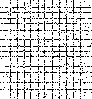

In [63]:
media.show_image(hh.grid_from_string(puzzle.input) == 'L', border=True, width=250)

In [64]:
s1 = """\
L.LL.LL.LL
LLLLLLL.LL
L.L.L..L..
LLLL.LL.LL
L.LL.LL.LL
L.LLLLL.LL
..L.L.....
LLLLLLLLLL
L.LLLLLL.L
L.LLLLL.LL
"""

In [65]:
# Relatively fast non-numba solution, which maintains neighbor counts.
# It becomes faster with numba enabled, but not as fast as the next solution.
def day11a(s, *, part2=False):
  # -1 is EMPTY, 0..8 is FREE+neighbor_count, 10..18 is OCCUPIED+neighbor_count
  int_from_ch = {'.': -1, 'L': 0, '#': 10}
  grid = hh.grid_from_string(s, int_from_ch)
  # Surprisingly, the default array dtype (here, np.int64) is the fastest.
  shape = grid.shape
  NEIGHBORS = tuple(set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)})

  def evolve(grid):
    def impact_neighbor_counts(y0, x0, delta):
      for dy, dx in NEIGHBORS:
        y, x = y0 + dy, x0 + dx
        while 0 <= y < shape[0] and 0 <= x < shape[1]:
          if not part2 or grid[y, x] >= 0:
            if grid[y, x] >= 0:
              grid[y, x] += delta
            break
          y, x = y + dy, x + dx

    # print('num_occupied', np.count_nonzero(grid >= 10))
    prev = grid.copy()
    for y in range(shape[0]):
      for x in range(shape[1]):
        if prev[y, x] == 0:  # FREE with zero occupied neighbors
          grid[y, x] += 10
          impact_neighbor_counts(y, x, +1)
        elif prev[y, x] >= (15 if part2 else 14):  # OCCUPIED, >= 5 or 4 neighb
          grid[y, x] -= 10
          impact_neighbor_counts(y, x, -1)
    return np.any(grid != prev)

  while evolve(grid):
    pass

  return np.count_nonzero(grid >= 10)


check_eq(day11a(s1), 37)
day11a_part2 = functools.partial(day11a, part2=True)
check_eq(day11a_part2(s1), 26)

if not using_numba:  # Best non-numba solutions.
  puzzle.verify(1, day11a)  # ~2500 ms.
  puzzle.verify(2, day11a_part2)  # ~5800 ms.

In [66]:
# More naive solution, but faster when using numba.
@numba.njit(parallel=True)
def day11_evolve(grid, neighbors, part2):
  shape = grid.shape
  EMPTY, FREE, OCCUPIED = 0, 1, 2

  def count_occupied_neighbors(grid, y0, x0, only_adjacent):
    count = 0
    for dy, dx in neighbors:
      y, x = y0 + dy, x0 + dx
      while 0 <= y < shape[0] and 0 <= x < shape[1]:
        if grid[y, x] != EMPTY or only_adjacent:
          count += grid[y, x] == OCCUPIED
          break
        y, x = y + dy, x + dx
    return count

  prev = grid.copy()
  for y in range(shape[0]):
    for x in range(shape[1]):
      num_occupied = count_occupied_neighbors(prev, y, x, not part2)
      if prev[y, x] == FREE and num_occupied == 0:
        grid[y, x] = OCCUPIED
      elif prev[y, x] == OCCUPIED and num_occupied >= (5 if part2 else 4):
        grid[y, x] = FREE
  return not np.all(grid == prev)


def day11(s, *, part2=False, return_video=False):
  int_from_ch = {'.': 0, 'L': 1, '#': 2}
  grid = hh.grid_from_string(s, int_from_ch)
  neighbors = tuple(set(itertools.product((-1, 0, 1), repeat=2)) - {(0, 0)})
  OCCUPIED = 2

  images = []
  while day11_evolve(grid, neighbors, part2):
    if return_video:
      image = (grid == OCCUPIED).repeat(2, axis=0).repeat(2, axis=1)
      images.append(image)

  if return_video:
    # We view only the even-numbered frames to avoid flashing on/off.
    images = [images[0]] * 10 + images[::2] + [images[-1]] * 10
    return images
  return np.count_nonzero(grid == OCCUPIED)


check_eq(day11(s1), 37)  # ~2000 ms for numba compilation.
day11_part2 = functools.partial(day11, part2=True)
check_eq(day11_part2(s1), 26)

if using_numba:
  puzzle.verify(1, day11)  # ~32 ms with numba; ~24 s without numba.
  puzzle.verify(2, day11_part2)  # ~49 ms with numba; ~27 s without numba.

(Part 1: 0.016 s)
(Part 2: 0.039 s)


Part 1,Part 2

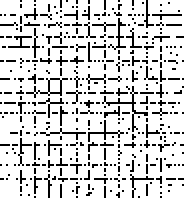
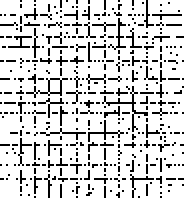

In [67]:
if using_numba:
  videos = {
      'Part 1': day11(puzzle.input, return_video=True),
      'Part 2': day11_part2(puzzle.input, return_video=True),
  }
  media.show_videos(videos, codec='gif', fps=10, border=True)
  del videos

<a name="day12"></a>
## Day 12: Ship and waypoint navigation

Given a list of instructions (a translation direction `N|S|E|W` and magnitude, a rotation `L|R` and angle (positive multiple of 90 degrees), or a forward directive `F` and value), update a ship's position and orientation in a 2D domain.

- Part 1: The translation, rotation, and forward instructions directly modify the ship's state.  After applying all instructions, report the Manhattan distance of the ship's position from its start.

- Part 2: The translation and rotation instructions modify a vector waypoint (initially 10 units east and 1 unit north of ship) relative to the ship position.  The forward instruction translates the ship position by the vector waypoint times the forward value.  Again report the final Manhattan distance of the ship from its start.

In [68]:
puzzle = advent.puzzle(day=12)

For [day 12](https://adventofcode.com/2020/day/12), `puzzle.input` has 773 lines:

W5
F63
S1
L90
F89
W4
F45
W4
 ...
L90
F94
L90
F13


The stored answers are: `{1: '1221', 2: '59435'}`

In [69]:
s1 = """\
F10
N3
F7
R90
F11
"""

In [70]:
def day12_part1(s):
  y, x = 0, 0
  dy, dx = 0, 1  # east

  for instruction in s.split():
    action, value = instruction[:1], int(instruction[1:])
    if action == 'N':
      y -= value
    elif action == 'S':
      y += value
    elif action == 'E':
      x += value
    elif action == 'W':
      x -= value
    elif action == 'L':
      while value:
        dy, dx = -dx, +dy
        value -= 90
    elif action == 'R':
      while value:
        dy, dx = +dx, -dy
        value -= 90
    elif action == 'F':
      y, x = y + dy * value, x + dx * value
  return abs(y) + abs(x)


check_eq(day12_part1(s1), 25)
puzzle.verify(1, day12_part1)  # ~1 ms.

(Part 1: 0.000 s)


In [71]:
def day12_part2(s):
  ship_y, ship_x = 0, 0
  # waypoint is relative to the ship
  waypoint_y, waypoint_x = -1, 10  # 10 units east and 1 unit north of ship

  for instruction in s.split():
    action, value = instruction[:1], int(instruction[1:])
    if action == 'N':
      waypoint_y -= value
    elif action == 'S':
      waypoint_y += value
    elif action == 'E':
      waypoint_x += value
    elif action == 'W':
      waypoint_x -= value
    elif action == 'L':
      while value:
        waypoint_y, waypoint_x = -waypoint_x, +waypoint_y
        value -= 90
    elif action == 'R':
      while value:
        waypoint_y, waypoint_x = +waypoint_x, -waypoint_y
        value -= 90
    elif action == 'F':
      ship_y += waypoint_y * value
      ship_x += waypoint_x * value
  return abs(ship_y) + abs(ship_x)


check_eq(day12_part2(s1), 286)
puzzle.verify(2, day12_part2)  # ~1 ms.

(Part 2: 0.000 s)


<a name="day13"></a>
## Day 13: Buses modulo schedule

Given a sequence of buses with different departure periods, all starting at time 0, with some buses out-of-service, find some earliest time satisfying a condition.

- Part 1: Given also an earliest time, find the first bus that departs on or after that time.  Report the wait time multiplied by the bus period.

- Part 2: Find the earliest time such that the first bus in the sequence departs at that time and each subsequent listed bus departs at the subsequent time if the bus is in service.

In [72]:
puzzle = advent.puzzle(day=13)

For [day 13](https://adventofcode.com/2020/day/13), `puzzle.input` has 2 lines:

1000299
41,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,37,x,x,x, ... ,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,19


The stored answers are: `{1: '156', 2: '404517869995362'}`

In [73]:
s1 = """\
939
7,13,x,x,59,x,31,19
"""

In [74]:
def day13_part1(s):
  lines = s.splitlines()
  earliest_time = int(lines[0])
  buses = [int(e) for e in lines[1].split(',') if e != 'x']
  next_times = [math.ceil(earliest_time / bus) * bus for bus in buses]
  min_time, min_bus = min(zip(next_times, buses))
  return (min_time - earliest_time) * min_bus


check_eq(day13_part1(s1), 295)
puzzle.verify(1, day13_part1)  # ~0 ms.

(Part 1: 0.000 s)


Part 2

In [75]:
# Let each bus be represented by its period b_i and desired remainder r_i.

# Given [(b_i, r_i)], where b_i are coprime, we seek x such that
#  x % b_i = r_i  for all i,  where r_i = -i % b_i
# We can work by reduction, merging pairs of buses.

# Given a pair of buses (b1, r1) and (b2, r2),
# we want to find a new equivalent bus (b1 * b2, r) such that
#  0 <= r < b1 * b2
#  r % b1 = r1
#  r % b2 = r2
# We can apply the Chinese remainder theorem using the extended GCD algorithm.

In [76]:
def extended_gcd(a: int, b: int) -> tuple[int, int, int]:
  """Finds the greatest common divisor using the extended Euclidean algorithm.

  Returns:
    (gcd(a, b), x, y) with the property that a * x + b * y = gcd(a, b).

  >>> extended_gcd(29, 71)
  (1, -22, 9)
  >>> (29 * -22) % 71
  1
  """
  prev_x, x = 1, 0
  prev_y, y = 0, 1
  while b:
    q = a // b
    x, prev_x = prev_x - q * x, x
    y, prev_y = prev_y - q * y, y
    a, b = b, a % b
  x, y = prev_x, prev_y
  return a, x, y


check_eq(extended_gcd(29, 71), ((1, -22, 9)))

In [77]:
def day13a_part2(s):  # Using pairwise reduction with extended_gcd.
  s = s.splitlines()[-1]
  buses = [int(e) for e in s.replace('x', '1').split(',')]
  check_eq(np.lcm.reduce(buses), math.prod(buses))  # verify all coprime
  bus_remainders = [(bus, -i % bus) for i, bus in enumerate(buses)]  # Optionally "if bus > 1".

  def merge_buses(bus1, bus2):
    (b1, r1), (b2, r2) = bus1, bus2
    # https://en.wikipedia.org/wiki/Chinese_remainder_theorem
    _, x, y = extended_gcd(b1, b2)
    return b1 * b2, (r1 * y * b2 + r2 * x * b1) % (b1 * b2)

  _, r = functools.reduce(merge_buses, bus_remainders)
  return r


check_eq(day13a_part2(s1.splitlines()[1]), 1068781)
check_eq(day13a_part2('17,x,13,19'), 3417)
check_eq(day13a_part2('67,7,59,61'), 754018)
check_eq(day13a_part2('67,x,7,59,61'), 779210)
check_eq(day13a_part2('67,7,x,59,61'), 1261476)
check_eq(day13a_part2('1789,37,47,1889'), 1202161486)
puzzle.verify(2, day13a_part2)  # ~0 ms.

(Part 2: 0.000 s)


In [78]:
def day13_part2(s):  # Using built-in modular inverses and general Chinese Remainder method.
  s = s.splitlines()[-1]
  buses = [int(e) for e in s.replace('x', '1').split(',')]
  check_eq(np.lcm.reduce(buses), math.prod(buses))  # verify all coprime
  remainders, moduli = zip(*[(-i % bus, bus) for i, bus in enumerate(buses)])  # Or "if bus > 1".

  def solve_mod_congruences(values: Iterable[int], moduli: Iterable[int]) -> int:
    """Returns `x` satisfying `values[i] == x % moduli[i]`.

    The Chinese Remainder Theorem shows the system has a unique solution if `moduli` are coprime.
    See https://en.wikipedia.org/wiki/Modular_multiplicative_inverse#Applications .

    Args:
      values: Desired remainders with respect to a corresponding sequence of moduli.
      moduli: Positive integers, which must be coprime.

    >>> solve_mod_congruences([3, 6, 6], [5, 7, 11])
    39
    """
    values, moduli = tuple(values), tuple(moduli)
    assert len(values) == len(moduli) > 0
    mod_prod = math.prod(moduli)
    other_mods = [mod_prod // mod for mod in moduli]
    inverses = [pow(other_mod, -1, mod=mod) for other_mod, mod in zip(other_mods, moduli)]
    return (
        sum(
            inverse * other_mod * value
            for inverse, other_mod, value in zip(inverses, other_mods, values)
        )
        % mod_prod
    )

  return solve_mod_congruences(remainders, moduli)


check_eq(day13_part2(s1.splitlines()[1]), 1068781)
check_eq(day13_part2('17,x,13,19'), 3417)
check_eq(day13_part2('67,7,59,61'), 754018)
check_eq(day13_part2('67,x,7,59,61'), 779210)
check_eq(day13_part2('67,7,x,59,61'), 1261476)
check_eq(day13_part2('1789,37,47,1889'), 1202161486)
puzzle.verify(2, day13_part2)  # ~0 ms.

(Part 2: 0.000 s)


<a name="day14"></a>
## Day 14: Write masked values to mem

Process a sequence of instructions, each specifying either a bitmask (where each location contains `0`, `1`, or `X`) or the writing of a value to a memory address, and report the sum of the resulting memory contents.

- Part 1: The bitmask is applied to the value written to memory, such that `0` and `1` replace the corresponding bit in the value and `X` leaves it unchanged.

- Part 2: The bitmask is applied to the address used to write the value to memory, such that `1` replaces the corresponding bit in the address and `X` indicates a wildcard.  The value is written to all memory addresses satisfying the wildcard.

In [79]:
puzzle = advent.puzzle(day=14)

For [day 14](https://adventofcode.com/2020/day/14), `puzzle.input` has 570 lines:

mask = 0111X10100100X1111X10010X000X1000001
mem[50907] = 468673978
mem[22295] = 3337449
mem[58474] = 56418393
mem[15362] = 243184
mem[65089] = 110688658
mask = 010X010XX110X01X01X10X001001011X110X
mem[21952] = 950257
 ...
mem[13666] = 52961
mem[7377] = 134144120
mem[58224] = 211536
mem[36878] = 173058887


The stored answers are: `{1: '9628746976360', 2: '4574598714592'}`

In [80]:
s1 = """\
mask = XXXXXXXXXXXXXXXXXXXXXXXXXXXXX1XXXX0X
mem[8] = 11
mem[7] = 101
mem[8] = 0
"""

In [81]:
s2 = """\
mask = 000000000000000000000000000000X1001X
mem[42] = 100
mask = 00000000000000000000000000000000X0XX
mem[26] = 1
"""

In [82]:
def day14(s, *, part2=False):
  mem = {}
  extract_0 = str.maketrans('01X', '100')
  extract_1 = str.maketrans('01X', '010')
  extract_x = str.maketrans('01X', '001')
  for line in s.splitlines():
    if line.startswith('mask'):
      mask = line.split(' = ')[1]
      if not part2:
        mask_force_0 = int(mask.translate(extract_0), base=2)
        mask_force_1 = int(mask.translate(extract_1), base=2)
      else:
        mask_force_1 = int(mask.translate(extract_1), base=2)
        mask_not_x = ~int(mask.translate(extract_x), base=2)
        offsets = [0]
        for wildcard in (1 << i for i in range(36) if mask[35 - i] == 'X'):
          offsets += [offset + wildcard for offset in offsets]
    else:
      address, value = map(int, hh.re_groups(r'^mem\[(\d+)\] = (\d+)$', line))
      if not part2:
        mem[address] = (value | mask_force_1) & ~mask_force_0
      else:
        address = (address & mask_not_x) | mask_force_1
        for offset in offsets:
          mem[address + offset] = value
  return sum(mem.values())


check_eq(day14(s1), 165)
puzzle.verify(1, day14)  # ~1 ms.

day14_part2 = functools.partial(day14, part2=True)
check_eq(day14_part2(s2), 208)
puzzle.verify(2, day14_part2)  # ~22 ms.

(Part 1: 0.001 s)
(Part 2: 0.010 s)


<a name="day15"></a>
## Day 15: Rounds of spoken numbers

Given an initial sequence of numbers indexed starting at `1`, continue the sequence as follows.

The number at index `i` is either
  * `0` if the number at index `i - 1` was not previously seen, or
  * `i - 1 - j` if the number at index `i - 1` was previously seen at index `j`.

- Part 1: Report the number at index `2020`.

- Part 2: Report the number at index `30_000_000`.

In [83]:
puzzle = advent.puzzle(day=15)

For [day 15](https://adventofcode.com/2020/day/15), `puzzle.input` has a single line of 16 characters:

9,12,1,4,17,0,18


The stored answers are: `{1: '610', 2: '1407'}`

In [84]:
s1 = '0,3,6'

In [85]:
def day15a(s, *, num_turns=2020):  # Slow, using dict().
  initial_sequence = tuple(map(int, s.split(',')))

  def generate_sequence(initial_sequence):
    last_turn: dict[int, int] = {}
    for turn, number in enumerate(initial_sequence):
      prev_turn = last_turn.get(number, -1)
      last_turn[number] = turn
      yield number

    for turn in itertools.count(len(initial_sequence)):
      number = 0 if prev_turn < 0 else turn - 1 - prev_turn
      prev_turn = last_turn.get(number, -1)
      last_turn[number] = turn
      yield number

  return next(itertools.islice(generate_sequence(initial_sequence), num_turns - 1, None))


check_eq(day15a(s1, num_turns=10), 0)
check_eq(day15a(s1), 436)
check_eq(day15a('1,3,2'), 1)
check_eq(day15a('2,1,3'), 10)
check_eq(day15a('1,2,3'), 27)
check_eq(day15a('2,3,1'), 78)
check_eq(day15a('3,2,1'), 438)
check_eq(day15a('3,1,2'), 1836)
puzzle.verify(1, day15a)  # ~1 ms.

day15a_part2 = functools.partial(day15a, num_turns=30_000_000)
# puzzle.verify(2, day15a_part2)  # Slow; ~15 s.

(Part 1: 0.000 s)


In [86]:
def day15b(s, *, num_turns=2020):  # Faster, using List.
  def func(initial_sequence, num_turns):
    last_turn = [-1] * num_turns
    for turn in range(min(num_turns, len(initial_sequence))):
      number = initial_sequence[turn]
      prev_turn = last_turn[number]
      last_turn[number] = turn

    for turn in range(len(initial_sequence), num_turns):
      number = 0 if prev_turn < 0 else turn - 1 - prev_turn
      prev_turn = last_turn[number]
      last_turn[number] = turn

    return number

  initial_sequence = np.array(tuple(map(int, s.split(','))), np.int32)
  return func(initial_sequence, num_turns)


check_eq(day15b(s1), 436)
puzzle.verify(1, day15b)  # ~1 ms.

if not using_numba:
  day15b_part2 = functools.partial(day15b, num_turns=30_000_000)
  # check_eq(day15b_part2(s1), 175594)  # Slow; ~9 s.
  puzzle.verify(2, day15b_part2)  # Slow; ~10 s.

(Part 1: 0.000 s)


In [87]:
# Faster, using np.array and numba.
@numba.njit
def day15_func(initial_sequence, num_turns):
  last_turn = np.full(num_turns, -1, np.int32)
  for turn in range(min(num_turns, len(initial_sequence))):
    number = initial_sequence[turn]
    prev_turn = last_turn[number]
    last_turn[number] = turn

  for turn in range(len(initial_sequence), num_turns):
    number = 0 if prev_turn < 0 else turn - 1 - prev_turn
    prev_turn = last_turn[number]
    last_turn[number] = turn

  return number


def day15(s, *, num_turns=2020):
  initial_sequence = np.array(tuple(map(int, s.split(','))), np.int32)
  return day15_func(initial_sequence, num_turns)


check_eq(day15(s1), 436)  # ~1 s for numba compilation.
puzzle.verify(1, day15)  # ~4 ms.

if using_numba:
  day15_part2 = functools.partial(day15, num_turns=30_000_000)
  check_eq(day15_part2(s1), 175594)  # ~1 s for numba compilation.
  if 0:
    check_eq(day15_part2('1,3,2'), 2578)
    check_eq(day15_part2('2,1,3'), 3544142)
    check_eq(day15_part2('1,2,3'), 261214)
    check_eq(day15_part2('2,3,1'), 6895259)
    check_eq(day15_part2('3,2,1'), 18)
    check_eq(day15_part2('3,1,2'), 362)
  puzzle.verify(2, day15_part2)  # ~650 ms with numba, ~110 s without numba.
  # (Without numba, accessing individual elements is much faster within
  # a Python list than within an np.array.)

(Part 1: 0.000 s)
(Part 2: 0.375 s)


<a name="day16"></a>
## Day 16: Match ticket fields and rules

Given (1) a set of fields with names and rules on possible value ranges, (2) my ticket with unlabeled fields, and (3) a set of other tickets with unlabeled fields:

- Part 1: Report the number of invalid other tickets, which are those containing a field value that does not satisfy any field rule.

- Part 2: Considering the valid other tickets, determine a labeling of the ticket fields that is compatible with the rules.  Report the product of the 6 field values on my ticket whose names start with `departure`.

In [73]:
puzzle = advent.puzzle(day=16)

For [day 16](https://adventofcode.com/2020/day/16), `puzzle.input` has 268 lines:

departure location: 33-679 or 691-971
departure station: 48-646 or 671-966
departure platform: 37-601 or 619-950
departure track: 41-863 or 875-973
departure date: 37-145 or 168-965
departure time: 26-246 or 257-972
arrival location: 30-542 or 556-960
arrival station: 30-75 or 89-954
 ...
845,453,939,349,884,940,0,621,933,188,73,204,440,918,207,671,629,735,487,627
879,694,125,501,580,274,451,885,834,397,146,104,185,173,528,717,590,412,350,936
944,91,450,631,262,501,196,401,199,946,105,236,634,765,66,385,582,437,262,581
924,594,156,702,128,858,133,695,140,486,399,534,115,627,748,560,518,700,883,206


The stored answers are: `{1: '29878', 2: '855438643439'}`

In [74]:
s1 = """\
class: 1-3 or 5-7
row: 6-11 or 33-44
seat: 13-40 or 45-50

your ticket:
7,1,14

nearby tickets:
7,3,47
40,4,50
55,2,20
38,6,12
"""

s2 = """\
class: 0-1 or 4-19
row: 0-5 or 8-19
seat: 0-13 or 16-19

your ticket:
11,12,13

nearby tickets:
3,9,18
15,1,5
5,14,9
"""

In [76]:
def day16(s, *, part2=False):
  def read_rules_and_tickets(s):
    s_rules, s_my_ticket, s_nearby = s.split('\n\n')

    def read_rules():
      for line in s_rules.splitlines():
        name, ranges = line.split(': ')
        ranges = ranges.split(' or ')
        yield name, [tuple(map(int, range.split('-'))) for range in ranges]

    (line,) = s_my_ticket.splitlines()[1:]
    my_ticket = list(map(int, line.split(',')))

    def read_tickets():
      for line in s_nearby.splitlines()[1:]:
        fields = list(map(int, line.split(',')))
        yield fields

    return read_rules, my_ticket, read_tickets

  def value_ok_for_some_rule(value, rules):
    return any(range[0] <= value <= range[1] for ranges in rules.values() for range in ranges)

  read_rules, my_ticket, read_tickets = read_rules_and_tickets(s)
  rules = dict(read_rules())

  if not part2:
    return sum(
        value
        for fields in read_tickets()
        for value in fields
        if not value_ok_for_some_rule(value, rules)
    )

  valid_tickets = [
      fields
      for fields in read_tickets()
      if all(value_ok_for_some_rule(value, rules) for value in fields)
  ]
  num_rules, num_fields = len(rules), len(valid_tickets[0])
  check_eq(num_rules, num_fields)

  def is_compatible(rule, field_index):
    ranges = rules[rule]
    return all(
        any(range[0] <= ticket[field_index] <= range[1] for range in ranges)
        for ticket in valid_tickets
    )

  grid = np.empty((num_rules, num_fields), bool)
  # Computational bottleneck; could let rules.values() be array and use numba.
  for rule_index, rule in enumerate(rules):
    for field_index in range(num_fields):
      grid[rule_index, field_index] = is_compatible(rule, field_index)

  list_rules = list(rules)
  column_of_rule = {}
  row_sums = grid.sum(axis=1)
  while row_sums.any():
    row = np.nonzero(row_sums == 1)[0][0]
    ((col,),) = np.nonzero(grid[row] == 1)
    rule = list_rules[row]
    column_of_rule[rule] = col
    row_sums -= grid[:, col]
    grid[:, col] = 0
  values = [my_ticket[column_of_rule[rule]] for rule in rules if rule.startswith('departure')]
  check_eq(len(values), 6)
  return math.prod(values)


check_eq(day16(s1), 71)
puzzle.verify(1, day16)  # ~6 ms.

day16_part2 = functools.partial(day16, part2=True)
puzzle.verify(2, day16_part2)  # ~52 ms.

(Part 1: 0.002 s)
(Part 2: 0.021 s)


<a name="day17"></a>
## Day 17: Game of life in 3D and 4D

Given an initial 2D grid of cell states, simulate a cellular automaton on a higher-dimensional grid.  An inactive grid cell becomes active if exactly 3 of its neighbors is active, and an active grid cell becomes inactive unless 2 or 3 of its neighbors is active.  (Each cell has 26 neighbors in 3D and 80 neighbors in 4D.)

- Part 1: Run the cellular automaton in 3D for 6 generations and report the number of active cells.

- Part 2: Do the same in 4D.

In [91]:
puzzle = advent.puzzle(day=17)

For [day 17](https://adventofcode.com/2020/day/17), `puzzle.input` has 8 lines:

.......#
....#...
...###.#
#...###.
....##..
##.#..#.
###.#.#.
....#...


The stored answers are: `{1: '232', 2: '1620'}`

In [92]:
s1 = """\
.#.
..#
###
"""

In [93]:
# Both of the solutions below work in arbitrary dimension!

In [94]:
def day17a(s, *, num_cycles=6, dim=3):  # Slower.
  lines = s.splitlines()
  indices = {
      (0,) * (dim - 2) + (y, x)
      for y, line in enumerate(lines)
      for x, ch in enumerate(line)
      if ch == '#'
  }
  offsets = set(itertools.product((-1, 0, 1), repeat=dim)) - {(0,) * dim}

  def neighbors(index):
    for offset in offsets:
      yield tuple(map(sum, zip(index, offset)))

  def count_neighbors(index):
    return sum(neighbor in indices for neighbor in neighbors(index))

  for _ in range(num_cycles):
    survivors = {index for index in indices if 2 <= count_neighbors(index) <= 3}
    adjacents = {neighbor for index in indices for neighbor in neighbors(index)}
    births = {index for index in adjacents if count_neighbors(index) == 3}
    indices = survivors | births

  return len(indices)


check_eq(day17a(s1), 112)
puzzle.verify(1, day17a)  # ~150 ms.

(Part 1: 0.052 s)


In [95]:
def day17(s, *, num_cycles=6, dim=3):  # Faster.
  lines = s.splitlines()
  indices = {
      (0,) * (dim - 2) + (y, x)
      for y, line in enumerate(lines)
      for x, ch in enumerate(line)
      if ch == '#'
  }
  offsets = set(itertools.product((-1, 0, 1), repeat=dim)) - {(0,) * dim}

  def neighbors(index):
    i = index
    if dim == 3:  # faster
      for o in offsets:
        yield i[0] + o[0], i[1] + o[1], i[2] + o[2]
    elif dim == 4:  # faster
      for o in offsets:
        yield i[0] + o[0], i[1] + o[1], i[2] + o[2], i[3] + o[3]
    else:
      for o in offsets:
        yield tuple(map(sum, zip(i, o)))

  for _ in range(num_cycles):
    # Adapted from collections.Counter() algorithm in
    # https://github.com/norvig/pytudes/blob/master/ipynb/Advent-2020.ipynb
    neighbor_counts = collections.Counter(
        more_itertools.flatten(neighbors(index) for index in indices)
    )
    indices = {
        index
        for index, count in neighbor_counts.items()
        if count == 3 or (count == 2 and index in indices)
    }

  return len(indices)


check_eq(day17(s1), 112)
puzzle.verify(1, day17)  # ~8 ms.

day17_part2 = functools.partial(day17, dim=4)
check_eq(day17_part2(s1), 848)
puzzle.verify(2, day17_part2)  # ~200 ms.

(Part 1: 0.003 s)
(Part 2: 0.057 s)


In [96]:
def day17_show_num_active_in_each_generation_for_2d_3d_4d():
  for dim in range(2, 5):
    print(dim, [day17(puzzle.input, num_cycles=num_cycles, dim=dim) for num_cycles in range(6)])


if 0:
  day17_show_num_active_in_each_generation_for_2d_3d_4d()

<a name="day18"></a>
## Day 18: Parsing math expression

Given a list of mathematical expressions with additions, multiplications, and parentheses, evaluate each expression and report the sum of resulting values.

- Part 1: Operators `+` and `*` have equal precedence and are applied left-to-right.

- Part 2: Operator `+` has higher precedence than `*` (which is unusual).

In [97]:
puzzle = advent.puzzle(day=18)

For [day 18](https://adventofcode.com/2020/day/18), `puzzle.input` has 380 lines:

7 + (9 * 8 + 5 + 5 * (3 * 4 * 7 + 6 * 4)) * ((3 * 6 + 3 * 4 * 7 * 4) + 4 * 3 * 5 + 5 * (5 * 6 + 7)) * 2 + 6 * 4
9 * 4 * ((9 * 8 + 9 + 2 + 9) + 2 * 9 + 2 + 2) * 5 * 6
3 * ((9 * 3 * 8 * 6 * 6 * 7) + 8) * 2 * 9 + 4 * 8
(3 + 4 + 4 * 4 + 9) + (7 + 6 + 2 * 8) * 9 + 7 * 8
9 + 6 + 6 + 9 * 9 * 5
(3 * 5 + (4 + 3 * 7 * 8) + 7 + 8 + 2) * 8 * (3 * 4 * 8) * ((4 + 5 * 2) * 7)
6 + (5 + 8 * (6 * 8 * 9 + 9 + 8 * 9) * 4 + (5 * 9)) * 2 + 2
(6 + 8 + (6 * 6 + 2) * 6 * (7 + 7 + 8 + 9)) * 3 + 8 + (6 * (8 + 8 + 9)) + 2
 ...
5 * 8 + (7 + 2 + 6) * (8 + 2 + 8 + 4 + 9) + (5 * 6 * 6 * 3) + 8
6 + (7 * 4 + 4 * 7 + 3 * 7) + 9 + 5 * 7 * 5
3 + 2 + 8 + (4 + 9 * 4 * 2 + (9 * 9 + 9 + 5) * 5) + 6
3 * 9 * 4 * (5 * 4 * (8 + 3))


The stored answers are: `{1: '4940631886147', 2: '283582817678281'}`

In [98]:
def day18a(strings, *, part2=False):  # Slower, more readable.
  def evaluate_line(s):
    def parse_term(i):
      if s[i] == '(':
        value, i = parse_sequence(i + 1)
        check_eq(s[i], ')')
        return value, i + 1
      if s[i].isdigit():
        value = int(s[i])
        return value, i + 1
      raise AssertionError

    def parse_sequence(i):
      value, i = parse_term(i)
      while i < len(s) and s[i] != ')':
        check_eq(s[i], ' ')
        check_eq(s[i + 2], ' ')
        if s[i + 1] == '+':
          value2, i = parse_term(i + 3)
          value += value2
        elif s[i + 1] == '*':
          value2, i = (parse_sequence if part2 else parse_term)(i + 3)
          value *= value2
        else:
          raise AssertionError
      return value, i

    value, i = parse_sequence(0)
    check_eq(i, len(s))
    return value

  return sum(evaluate_line(s) for s in strings.splitlines())


puzzle.verify(1, day18a)  # ~50 ms.

day18a_part2 = functools.partial(day18a, part2=True)
puzzle.verify(2, day18a_part2)  # ~55 ms.

(Part 1: 0.003 s)
(Part 2: 0.003 s)


In [99]:
def day18(strings, *, part2=False):  # Compact and faster.
  def evaluate_line(s: str) -> int:
    def eval_term(i: int) -> tuple[int, int]:
      return eval_seq(i + 1, eat=1) if s[i] == '(' else (int(s[i]), i + 1)

    def eval_seq(i: int, eat: int = 0) -> tuple[int, int]:
      value, i = eval_term(i)
      while i < len(s) and s[i] != ')':
        is_mul = s[i + 1] == '*'
        func = eval_seq if part2 and is_mul else eval_term
        value2, i = func(i + 3)  # type: ignore[operator]
        value = value * value2 if is_mul else value + value2
      return value, i + eat

    return eval_seq(0)[0]

  return sum(evaluate_line(s) for s in strings.splitlines())


check_eq(day18('1 + 2 * 3 + 4 * 5 + 6'), 71)
check_eq(day18('1 + (2 * 3) + (4 * (5 + 6))'), 51)
check_eq(day18('2 * 3 + (4 * 5)'), 26)
check_eq(day18('5 + (8 * 3 + 9 + 3 * 4 * 3)'), 437)
check_eq(day18('5 * 9 * (7 * 3 * 3 + 9 * 3 + (8 + 6 * 4))'), 12240)
check_eq(day18('((2 + 4 * 9) * (6 + 9 * 8 + 6) + 6) + 2 + 4 * 2'), 13632)
puzzle.verify(1, day18)  # ~4 ms.

day18_part2 = functools.partial(day18, part2=True)
check_eq(day18_part2('1 + 2 * 3 + 4 * 5 + 6'), 231)
check_eq(day18_part2('1 + (2 * 3) + (4 * (5 + 6))'), 51)
check_eq(day18_part2('2 * 3 + (4 * 5)'), 46)
check_eq(day18_part2('5 + (8 * 3 + 9 + 3 * 4 * 3)'), 1445)
check_eq(day18_part2('5 * 9 * (7 * 3 * 3 + 9 * 3 + (8 + 6 * 4))'), 669060)
check_eq(day18_part2('((2 + 4 * 9) * (6 + 9 * 8 + 6) + 6) + 2 + 4 * 2'), 23340)
puzzle.verify(2, day18_part2)  # ~6 ms.

(Part 1: 0.002 s)
(Part 2: 0.002 s)


<a name="day19"></a>
## Day 19: Message grammar

Given a set of context-free grammar rules and a set of words, report the number of words that are expressible in the grammar.

- Part 1: Use the initial grammar rules, which do not have cycles.

- Part 2: Replace two of the grammar rules, thereby introducing cycles.

In [100]:
puzzle = advent.puzzle(day=19)

For [day 19](https://adventofcode.com/2020/day/19), `puzzle.input` has 583 lines:

26: 97 126 | 123 57
122: 84 97 | 92 123
82: 97 138 | 123 130
80: 131 97
3: 123 107 | 97 66
101: 1 123 | 95 97
10: 97 138 | 123 107
83: 123 27 | 97 12
 ...
abaabababbbbbabababbabbaaaabbbba
baaaababbbabbbbaaababbab
bbbabbabaabbaabbabbaaabb
abaaaababaabbbbabbbbbbbbaaaaaaaababaaaabbbaaaaaabbbbaaabbbbababb


The stored answers are: `{1: '198', 2: '372'}`

In [101]:
# spellcheck=off
s1 = """\
0: 4 1 5
1: 2 3 | 3 2
2: 4 4 | 5 5
3: 4 5 | 5 4
4: "a"
5: "b"

ababbb
bababa
abbbab
aaabbb
aaaabbb
"""

s2 = """\
42: 9 14 | 10 1
9: 14 27 | 1 26
10: 23 14 | 28 1
1: "a"
11: 42 31
5: 1 14 | 15 1
19: 14 1 | 14 14
12: 24 14 | 19 1
16: 15 1 | 14 14
31: 14 17 | 1 13
6: 14 14 | 1 14
2: 1 24 | 14 4
0: 8 11
13: 14 3 | 1 12
15: 1 | 14
17: 14 2 | 1 7
23: 25 1 | 22 14
28: 16 1
4: 1 1
20: 14 14 | 1 15
3: 5 14 | 16 1
27: 1 6 | 14 18
14: "b"
21: 14 1 | 1 14
25: 1 1 | 1 14
22: 14 14
8: 42
26: 14 22 | 1 20
18: 15 15
7: 14 5 | 1 21
24: 14 1

abbbbbabbbaaaababbaabbbbabababbbabbbbbbabaaaa
bbabbbbaabaabba
babbbbaabbbbbabbbbbbaabaaabaaa
aaabbbbbbaaaabaababaabababbabaaabbababababaaa
bbbbbbbaaaabbbbaaabbabaaa
bbbababbbbaaaaaaaabbababaaababaabab
ababaaaaaabaaab
ababaaaaabbbaba
baabbaaaabbaaaababbaababb
abbbbabbbbaaaababbbbbbaaaababb
aaaaabbaabaaaaababaa
aaaabbaaaabbaaa
aaaabbaabbaaaaaaabbbabbbaaabbaabaaa
babaaabbbaaabaababbaabababaaab
aabbbbbaabbbaaaaaabbbbbababaaaaabbaaabba
"""
# spellcheck=on

In [102]:
def day19a(s, *, part2=False):  # Compact.
  section1, section2 = s.split('\n\n')
  rules = dict(line.split(': ') for line in section1.splitlines())
  if part2:
    rules.update({'8': '42 | 42 8', '11': '42 31 | 42 11 31'})

  def valid_expansion(symbols, text):
    if not symbols or not text:
      return not symbols and not text
    expansions = rules[symbols[0]]
    if expansions[0] == '"':
      return expansions[1] == text[0] and valid_expansion(symbols[1:], text[1:])
    return any(
        valid_expansion(expansion.split() + symbols[1:], text)
        for expansion in expansions.split(' | ')
    )

  return sum(valid_expansion(['0'], text) for text in section2.splitlines())


check_eq(day19a(s1), 2)
puzzle.verify(1, day19a)  # ~100 ms.

day19a_part2 = functools.partial(day19a, part2=True)
check_eq(day19a_part2(s2), 12)
puzzle.verify(2, day19a_part2)  # ~500 ms.

(Part 1: 0.039 s)
(Part 2: 0.173 s)


In [103]:
def day19(s, *, part2=False):  # Faster.
  section1, section2 = s.split('\n\n')
  rules = {
      int(symbol): (
          rhs[1] if rhs[0] == '"' else tuple(tuple(map(int, s.split())) for s in rhs.split(' | '))
      )
      for line in section1.splitlines()
      for symbol, rhs in (line.split(': '),)
  }
  if part2:
    # We are fortunate that in both modified rules, there is a symbol to the
    # left of the recursion, which forces the consumption of a character.
    rules.update({8: ((42,), (42, 8)), 11: ((42, 31), (42, 11, 31))})

  def valid_expansion(symbols, text):
    while True:
      if not symbols:
        return not text
      if not text:
        return False
      expansions = rules[symbols[0]]
      if isinstance(expansions, str):
        if expansions != text[0]:
          return False
        symbols, text = symbols[1:], text[1:]
        continue
      return any(valid_expansion(expansion + symbols[1:], text) for expansion in expansions)

  return sum(valid_expansion((0,), text) for text in section2.splitlines())


check_eq(day19(s1), 2)
puzzle.verify(1, day19)  # ~75 ms.

day19_part2 = functools.partial(day19, part2=True)
check_eq(day19_part2(s2), 12)
puzzle.verify(2, day19_part2)  # ~350 ms.

(Part 1: 0.026 s)
(Part 2: 0.118 s)


<a name="day20"></a>
## Day 20: Dragons in grid of tiles

Given a set of numbered 2D image tiles with binary values, assemble these tiles using rotations and flips into a 2D grid such that adjacent tiles have matching boundary values.

- Part 1: Return the product of the tile numbers for the 4 tiles that lie at the corners of the assembled 2D grid.

- Part 2: Given a 2D mask ("dragon"), find all possible locations for this mask (including rotations and flips) such that all active values in the mask are also active in the assembled grid.  Report the number of active grid nodes which are not covered by any found mask instance.

In [22]:
puzzle = advent.puzzle(day=20)

For [day 20](https://adventofcode.com/2020/day/20), `puzzle.input` has 1_728 lines:

Tile 2789:
.#..#...##
##...#....
#.#.##..#.
.#.##.##.#
....#....#
#.#......#
.....#....
 ...
#......#.#
..#.....#.
.#.#.##.##



The stored answers are: `{1: '18449208814679', 2: '1559'}`

In [23]:
s1 = """\
Tile 2311:
..##.#..#.
##..#.....
#...##..#.
####.#...#
##.##.###.
##...#.###
.#.#.#..##
..#....#..
###...#.#.
..###..###

Tile 1951:
#.##...##.
#.####...#
.....#..##
#...######
.##.#....#
.###.#####
###.##.##.
.###....#.
..#.#..#.#
#...##.#..

Tile 1171:
####...##.
#..##.#..#
##.#..#.#.
.###.####.
..###.####
.##....##.
.#...####.
#.##.####.
####..#...
.....##...

Tile 1427:
###.##.#..
.#..#.##..
.#.##.#..#
#.#.#.##.#
....#...##
...##..##.
...#.#####
.#.####.#.
..#..###.#
..##.#..#.

Tile 1489:
##.#.#....
..##...#..
.##..##...
..#...#...
#####...#.
#..#.#.#.#
...#.#.#..
##.#...##.
..##.##.##
###.##.#..

Tile 2473:
#....####.
#..#.##...
#.##..#...
######.#.#
.#...#.#.#
.#########
.###.#..#.
########.#
##...##.#.
..###.#.#.

Tile 2971:
..#.#....#
#...###...
#.#.###...
##.##..#..
.#####..##
.#..####.#
#..#.#..#.
..####.###
..#.#.###.
...#.#.#.#

Tile 2729:
...#.#.#.#
####.#....
..#.#.....
....#..#.#
.##..##.#.
.#.####...
####.#.#..
##.####...
##..#.##..
#.##...##.

Tile 3079:
#.#.#####.
.#..######
..#.......
######....
####.#..#.
.#...#.##.
#.#####.##
..#.###...
..#.......
..#.###...
"""

In [58]:
def day20(s, *, part2=False, visualize=False):
  tiles = {int(t[5:9]): hh.grid_from_string(t[11:]) for t in s.rstrip('\n').split('\n\n')}
  n = math.isqrt(len(tiles))

  if visualize:
    tiles_bool = [tile != '#' for tile in tiles.values()]
    media.show_images(tiles_bool, columns=n, border=True, height=30)

  rotations = tuple(range(8))  # 4 proper rotations * 2 flips

  def rotate(tile, rotation):
    return np.rot90(tile if rotation < 4 else tile[::-1], rotation % 4)

  def top_row(tile, rotation):
    # return rotate(tile, rotation)[0]  # equivalent but slower
    tile = tile if rotation < 4 else tile[::-1]
    rotation = rotation % 4
    return (
        tile[0]
        if rotation == 0
        else tile[:, -1]
        if rotation == 1
        else tile[-1, ::-1]
        if rotation == 2
        else tile[::-1, 0]
    )

  # List of (index, rotation) for up to 2 tiles whose top row matches the key.
  edge_list = collections.defaultdict(list)
  for index, tile in tiles.items():
    for rotation in rotations:
      edge_list[tuple(top_row(tile, rotation))].append((index, rotation))

  def is_corner(tile):  # A corner tile has 2 unique edges.
    return (
        sum(len(edge_list[tuple(top_row(tile, rotation))]) == 1 for rotation in rotations[:4]) == 2
    )

  corners = [index for index, tile in tiles.items() if is_corner(tile)]
  assert len(corners) == 4  # Exactly four tiles must be at the corners.
  if not part2:
    return math.prod(corners)

  # Place a first corner in the grid upper-left and determine its rotation.
  index = corners[0]
  tile = tiles[index]
  rotation, _ = (
      rotation
      for rotation in rotations  # 2 solutions due to flip
      if (
          len(edge_list[tuple(rotate(tile, rotation)[0])]) == 1
          and len(edge_list[tuple(rotate(tile, rotation)[:, 0])]) == 1
      )
  )
  layout = np.empty((n, n), object)
  layout[0, 0] = index, rotation

  def find(not_index, rot, desired):
    'Returns (index, rotation) of tile with top row matching desired after rot.'
    l = edge_list[tuple(desired)]
    index, rotation = next(((index, rotation) for index, rotation in l if index != not_index))
    return index, (rotation + rot) % 4 + rotation // 4 * 4

  for y, x in np.ndindex(n, n):
    if x > 0:
      left_index, left_rotation = layout[y, x - 1]
      desired_left = rotate(tiles[left_index], left_rotation)[::-1, -1]
      layout[y, x] = find(left_index, 1, desired_left)
    elif y > 0:
      top_index, top_rotation = layout[y - 1, x]
      desired_top = rotate(tiles[top_index], top_rotation)[-1, :]
      layout[y, x] = find(top_index, 0, desired_top)

  def block(y, x):
    index, rotation = layout[y, x]
    return rotate(tiles[index], rotation)[1:-1, 1:-1]

  grid = np.block([[block(y, x) for x in range(n)] for y in range(n)])

  pattern0 = '                  # #    ##    ##    ### #  #  #  #  #  #   '
  pattern = np.array(list(pattern0)).reshape(3, 20) == '#'

  if 0:  # slower
    pattern_indices = pattern.nonzero()
    for rotation in rotations:
      grid_view = rotate(grid, rotation)
      for y, x in np.ndindex(*(np.array(grid_view.shape) - pattern.shape)):
        subgrid_view = grid_view[y:, x:]
        if np.all(subgrid_view[pattern_indices] != '.'):
          subgrid_view[pattern_indices] = 'O'

  elif 0:  # faster, using 1-d matching
    grid_view_1d = grid.ravel()
    for rotation in rotations:
      pattern_view = rotate(pattern, rotation)
      pattern_indices = pattern_view.nonzero()
      pattern_indices_1d = np.ravel_multi_index(pattern_indices, grid.shape)
      for y, x in np.ndindex(*(np.array(grid.shape) - pattern_view.shape)):
        subgrid_view_1d = grid_view_1d[y * grid.shape[1] + x :]
        if np.all(subgrid_view_1d[pattern_indices_1d] != '.'):
          subgrid_view_1d[pattern_indices_1d] = 'O'

  else:  # fastest, using 2d correlation
    import scipy.signal

    pattern_uint8 = pattern.astype(np.uint8)
    grid_uint8 = (grid == '#').astype(np.uint8)
    for rotation in rotations:
      pattern_view = rotate(pattern_uint8, rotation)
      pattern_indices = pattern_view.nonzero()
      corr = scipy.signal.correlate2d(grid_uint8, pattern_view, mode='valid')
      locations = zip(*np.nonzero(corr == pattern_view.sum()))
      for y, x in locations:
        grid[y:, x:][pattern_indices] = 'O'

  if visualize:
    value_from_ch = {'.': 0.0, '#': -1.0, 'O': 1.0}
    lookup = np.zeros(256, np.float32)
    for ch, value in value_from_ch.items():
      lookup[ord(ch)] = value
    grid2 = lookup[grid.view(np.uint32).astype(np.uint8)]
    grid2 = grid2.repeat(3, axis=0).repeat(3, axis=1)
    media.show_image(grid2, border=True)

  return np.count_nonzero(grid == '#')


check_eq(day20(s1), 20899048083289)
puzzle.verify(1, day20)  # ~12 ms.

day20_part2 = functools.partial(day20, part2=True)
check_eq(day20_part2(s1), 273)
puzzle.verify(2, day20_part2)  # ~31 ms.

(Part 1: 0.006 s)
(Part 2: 0.013 s)


,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,
,,,,,,,,,,,


""

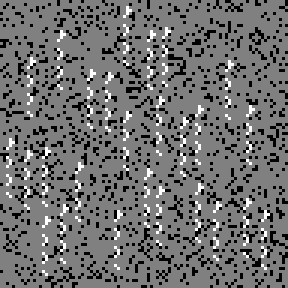

In [26]:
_ = day20_part2(puzzle.input, visualize=True)

In [28]:
# hh.prun(lambda: [day20_part2(puzzle.input) for _ in range(10)])

<a name="day21"></a>
## Day 21: Allergens in ingredients

Given a set of foods, each containing a list of ingredients and a set of allergens contained in the ingredients, determine the ingredient corresponding to each allergen.  Each allergen is contained in at most one ingredient.  Some foods may fail to list all allergens.

- Part 1: For each food, count the number of ingredients which cannot possibly contain allergens, and report the sum.

- Part 2: Report the comma-separated list of ingredients which contain allergens, sorted in ascending order by the allergen name.

In [77]:
puzzle = advent.puzzle(day=21)

For [day 21](https://adventofcode.com/2020/day/21), `puzzle.input` has 42 lines:

xfvxzl nfcrh kscdhn khnqq jkvcbf jhlvrg chc fk zbh hgrptqb zrvtg tdhv jhqpdf jvj ... mxbbst (contains shellfish, sesame)
vxzpfp shlg zrvtg ghq vzn ppqs mqlnbjq cltpv pvxpgp psbnqz nqcmm sqjcsxjq xftxgf ... cbhfpzp khnqq dhqbf (contains fish)
fzhmtds zbclt pbln qtgv bnl xqcb vxzpfp jkvcbf nnst tplrt xknj hzmvzrr xfvxzl gk ...  (contains sesame, fish, shellfish)
ghq vfqh vtdbl bkmgx bxlc sbhdb xfvxzl lvdcdg nsktq hrjrm dbr prrfm dbqbv jbcjk  ... gpgql dpkkzdgs cjds (contains nuts)
xknj bbbzcmh tzrp xkqgc ktfvb tplrt dqz ntq jbcjk pcnmbt nqcmm tlgchbh bxfvt nfs ... hlvrg fhznhmx (contains dairy, soy)
strd dpdgc cjdnjf flmssjn xfpc mmdfrfcp gpp tqjg znkr mxbbst bbbzcmh jbvrzn cdsl ... mx xknh schkf (contains soy, wheat)
gkgzn bndz dpkkzdgs nv nhjbd mqlnbjq khnqq ljpzx cfbgb xknj ddmg mkpmkx tgcvz nn ... trd tdhv fk tdsvx (contains sesame)
gnfjcpc ddmg tpbtpd cltpv xfvxzl txr rmxzzf tgcvz jsdgn pgnk jrpx vbvfr vzn gbpl ... c dvzqx hcms zrvtg (contains dairy)
 ...
nsktq ftkfc mdqlbx bxfvt vt

The stored answers are: `{1: '2410', 2: 'tmp,pdpgm,cdslv,zrvtg,ttkn,mkpmkx,vxzpfp,flnhl'}`

In [78]:
s1 = """\
mxmxvkd kfcds sqjhc nhms (contains dairy, fish)
trh fvjkl sbzzf mxmxvkd (contains dairy)
sqjhc fvjkl (contains soy)
sqjhc mxmxvkd sbzzf (contains fish)
"""

In [80]:
def day21(s, *, part2=False):
  def foods():
    for line in s.splitlines():
      ingredients, allergens = line[:-1].split(' (contains ')
      yield set(ingredients.split()), allergens.split(', ')

  possibles_for_allergen = {}
  for ingredients, allergens in foods():
    for allergen in allergens:
      if allergen not in possibles_for_allergen:
        possibles_for_allergen[allergen] = ingredients.copy()
      else:
        possibles_for_allergen[allergen] &= ingredients

  def has_single_ingredient(item):
    return len(item[1]) == 1

  allergen_ingredient = {}
  while possibles_for_allergen:
    allergen, ingredients = next(filter(has_single_ingredient, possibles_for_allergen.items()))
    ingredient = ingredients.pop()
    allergen_ingredient[allergen] = ingredient
    for ingredients2 in possibles_for_allergen.values():
      ingredients2.discard(ingredient)
    del possibles_for_allergen[allergen]

  if not part2:
    allergen_ingredients = set(allergen_ingredient.values())
    return sum(len(ingredients - allergen_ingredients) for ingredients, _ in foods())

  return ','.join(ingredient for _, ingredient in sorted(allergen_ingredient.items()))


check_eq(day21(s1), 5)
puzzle.verify(1, day21)  # ~1 ms.

day21_part2 = functools.partial(day21, part2=True)
check_eq(day21_part2(s1), 'mxmxvkd,sqjhc,fvjkl')
puzzle.verify(2, day21_part2)  # ~1 ms.

(Part 1: 0.001 s)
(Part 2: 0.000 s)


<a name="day22"></a>
## Day 22: Recursive card game

Given two hands of integer cards, simulate a card game of combat.  At each turn, the player with the largest front card places the two cards (higher card first) at the back of their hand.  A player that owns all cards wins.

- Part 1: In the winner's hand, multiply each card value by its position (1 being rearmost), and report the sum of the result.

- Part 2: Add extra rules.  If both players have at least as many cards remaining in their deck as their top card, the winner of the round is determined by playing a new game of Recursive Combat.  See the [website](https://adventofcode.com/2020/day/22) for details.

In [111]:
puzzle = advent.puzzle(day=22)

For [day 22](https://adventofcode.com/2020/day/22), `puzzle.input` has 53 lines:

Player 1:
15
31
26
4
36
30
43
 ...
37
5
1
27


The stored answers are: `{1: '32199', 2: '33780'}`

In [112]:
s1 = """\
Player 1:
9
2
6
3
1

Player 2:
5
8
4
7
10
"""

In [113]:
def day22_part1(s):
  hands = [collections.deque(map(int, s2.splitlines()[1:])) for s2 in s.split('\n\n')]

  while hands[0] and hands[1]:
    cards = hands[0].popleft(), hands[1].popleft()
    winner = 0 if cards[0] > cards[1] else 1
    hands[winner].extend([cards[winner], cards[1 - winner]])

  return sum((i + 1) * card for i, card in enumerate(reversed(hands[winner])))


check_eq(day22_part1(s1), 306)
puzzle.verify(1, day22_part1)  # ~0 ms.

(Part 1: 0.000 s)


Part 2

In [114]:
def day22a_part2(s):  # Slower code using deque.
  def combat(hands):  # Returns (hands, winner)
    visited = set()
    while hands[0] and hands[1]:
      state = (*hands[0], -1, *hands[1])
      if state in visited:
        return hands, 0  # player 1 is winner
      visited.add(state)
      cards = hands[0].popleft(), hands[1].popleft()
      if len(hands[0]) >= cards[0] and len(hands[1]) >= cards[1]:
        _, winner = combat([
            collections.deque(list(hands[0])[: cards[0]]),
            collections.deque(list(hands[1])[: cards[1]]),
        ])
      else:
        winner = 0 if cards[0] > cards[1] else 1
      hands[winner].extend([cards[winner], cards[1 - winner]])

    return hands, 0 if hands[0] else 1

  hands = [collections.deque(map(int, s2.splitlines()[1:])) for s2 in s.split('\n\n')]
  hands, winner = combat(hands)
  return sum((i + 1) * card for i, card in enumerate(reversed(hands[winner])))


check_eq(day22a_part2(s1), 291)
# puzzle.verify(2, day22a_part2)  # ~1750 ms.

In [115]:
def day22_part2(s):  # Faster code using tuples.

  # @functools.lru_cache(maxsize=None)  # It makes no difference.
  def combat(hand0, hand1):
    visited = set()
    while True:
      state = hand0, hand1
      if state in visited:
        return (0,), ()  # player 1 is winner
      visited.add(state)
      card0 = hand0[0]
      card1 = hand1[0]
      recurse = len(hand0) > card0 and len(hand1) > card1
      if combat(hand0[1 : card0 + 1], hand1[1 : card1 + 1])[0] if recurse else card0 > card1:
        hand0, hand1 = hand0[1:] + (card0, card1), hand1[1:]
        if not hand1:
          break
      else:
        hand0, hand1 = hand0[1:], hand1[1:] + (card1, card0)
        if not hand0:
          break
    return hand0, hand1

  hand0, hand1 = (tuple(map(int, s2.splitlines()[1:])) for s2 in s.split('\n\n'))
  hand0, hand1 = combat(hand0, hand1)
  return sum((i + 1) * card for i, card in enumerate(reversed(hand0 + hand1)))


check_eq(day22_part2(s1), 291)
puzzle.verify(2, day22_part2)  # ~1200 ms.

(Part 2: 0.407 s)


In [116]:
# # %timeit -r8 day22_part2(puzzle.input)

In [117]:
# # %prun day22_part2(puzzle.input)  # No obvious opportunity for optimization.

<a name="day23"></a>
## Day 23: Cups in a circle

Given a circular list of cups (labeled 1-9), apply a sequence of moves.
For each move, extract the 3 cups to the right of the current cup (initially first in the input), and reinsert the 3 cups to the right of the cup whose label has value 1 less than the current cup.  Advance the current cup to the right.

When finding the cup whose label has value 1 less than the current cup, skip over any that are in the 3 extracted cups, and when reaching value 0, wraparound back to the highest value.

- Part 1: Report the cup labels (as a string of 8 digits) to the right of cup 1 after 100 moves.

- Part 2: Extend the input circular list to contain a total of 1_000_000 cups, labeled 10 .. 1_000_000.  After 10_000_000 moves, determine the two cups to the right of cup 1, and report the product of their labels.

In [118]:
puzzle = advent.puzzle(day=23)

For [day 23](https://adventofcode.com/2020/day/23), `puzzle.input` has a single line of 9 characters:

872495136


The stored answers are: `{1: '27865934', 2: '170836011000'}`

In [119]:
s1 = '389125467'

In [120]:
def day23a(s, *, num_moves=100):  # Using list.
  l = list(map(int, s.strip()))

  for _ in range(num_moves):
    (current, *extracted3) = l[:4]
    destination = current - 1 if current > 1 else len(l)
    while destination in extracted3:
      destination = destination - 1 if destination > 1 else len(l)
    dest = l.index(destination)  # bottleneck in part 2!
    l = l[4 : dest + 1] + extracted3 + l[dest + 1 :] + [current]

  i = l.index(1)
  l = l[i + 1 :] + l[:i]
  return ''.join(map(str, l))


check_eq(day23a(s1, num_moves=10), '92658374')
check_eq(day23a(s1), '67384529')

In [121]:
def day23b(s, *, num_moves=100):  # Using deque.
  d = collections.deque(map(int, s.strip()))
  n = len(d)

  for _ in range(num_moves):
    current = next(iter(d))
    d.rotate(-1)  # move current to the end
    extracted3 = d.popleft(), d.popleft(), d.popleft()
    destination = current - 1 if current > 1 else n
    while destination in extracted3:
      destination = destination - 1 if destination > 1 else n
    dest = d.index(destination)  # bottleneck in part 2!
    d.rotate(-dest - 1)  # move destination to end
    d.extendleft(reversed(extracted3))
    d.rotate(dest + 1)  # move new current back to front

  d.rotate(-d.index(1))  # move '1' to front
  d.popleft()  # remove '1'
  return ''.join(map(str, d))


check_eq(day23b(s1, num_moves=10), '92658374')
check_eq(day23b(s1), '67384529')

In [122]:
# Code keeping track of next cup label for each cup label:
@numba.njit  # 0.25 s to jit on first invocation
def day23_func(l, max_num, num_moves, next_cup):
  n = len(next_cup) - 1
  current = l[0]
  for i in range(len(l) - 1):
    next_cup[l[i]] = l[i + 1]
  if max_num:
    next_cup[l[-1]] = len(l) + 1
    for i in range(len(l) + 1, max_num):
      next_cup[i] = i + 1
    next_cup[max_num] = l[0]
  else:
    next_cup[l[-1]] = l[0]

  for _ in range(num_moves):
    extracted1 = next_cup[current]
    extracted2 = next_cup[extracted1]
    extracted3 = next_cup[extracted2]
    destination = current - 1 if current > 1 else n
    while destination in (extracted1, extracted2, extracted3):
      destination = destination - 1 if destination > 1 else n
    next_cup[current] = next_cup[extracted3]
    next_cup[extracted3] = next_cup[destination]
    next_cup[destination] = extracted1
    current = next_cup[current]


def day23(s, *, max_num=0, num_moves=100):
  dtype = np.int32 if using_numba else np.int64
  l = np.array(list(map(int, s.strip())), dtype)
  next_cup = np.empty(1 + max(len(l), max_num), l.dtype)
  day23_func(l, max_num, num_moves, next_cup)
  if max_num:
    cup1 = next_cup[1]
    cup2 = next_cup[cup1]
    return int(cup1) * int(cup2)
  ll = [next_cup[1]]
  while next_cup[ll[-1]] != 1:
    ll.append(next_cup[ll[-1]])
  return ''.join(map(str, ll))


check_eq(day23(s1, num_moves=10), '92658374')
check_eq(day23(s1), '67384529')
puzzle.verify(1, day23)  # ~6 ms with numba; ~1 ms without numba.

day23_part2 = functools.partial(day23, num_moves=10_000_000, max_num=1_000_000)
if using_numba:
  check_eq(day23_part2(s1), 149245887792)
puzzle.verify(2, day23_part2)  # ~400 ms with numba; ~25 s without numba.

(Part 1: 0.000 s)
(Part 2: 0.177 s)


In [123]:
# # %timeit -r8 day23_part2(puzzle.input)

<a name="day24"></a>
## Day 24: Hexagonal tiles

For each input line, travel over a hexagonal grid using the substrings `e`, `w`, `ne`, `nw`, `se`, and `sw`, and flip the state of the reached grid cell.  (Initially all grid cells are inactive.)

- Part 1: Report the number of active cells in the resulting hexagonal grid.

- Part 2: Simulate a cellular automaton over the grid from part 1, where an inactive cell becomes active if it has exactly 2 active neighbors,
and an active cell becomes inactive if it has 0 or more than 2 active neighbors.  Report the number of active cells after 100 steps.

In [41]:
puzzle = advent.puzzle(day=24)

For [day 24](https://adventofcode.com/2020/day/24), `puzzle.input` has 347 lines:

enwwsenweswweseseswnenewwswseswenw
nwnwneswwnenwnwnwenenwwnesenenwsenenee
eneswwenwneeswneenenw
swwswswwwswswsweeswww
swewnwneeewnewwwswwnwwswswnwww
seswnwenesenwsenenwwenwsenwswnwseswnw
nwswwenwwwswwnwnewswnwnwwwswnee
seswseswseseseseeseseseswnwsesw
 ...
nwnwnwnwnewnwwwnwnwnenenwsenwsesenwnww
nwwswneseseswsenweswswswneswwswwswswsw
neenwsenenenenenenwswswnenenwsenenene
newnwnwnwnwwnweswwewsewenwwnwnwnwnw


The stored answers are: `{1: '287', 2: '3636'}`

In [42]:
# spellcheck=off
s1 = """\
sesenwnenenewseeswwswswwnenewsewsw
neeenesenwnwwswnenewnwwsewnenwseswesw
seswneswswsenwwnwse
nwnwneseeswswnenewneswwnewseswneseene
swweswneswnenwsewnwneneseenw
eesenwseswswnenwswnwnwsewwnwsene
sewnenenenesenwsewnenwwwse
wenwwweseeeweswwwnwwe
wsweesenenewnwwnwsenewsenwwsesesenwne
neeswseenwwswnwswswnw
nenwswwsewswnenenewsenwsenwnesesenew
enewnwewneswsewnwswenweswnenwsenwsw
sweneswneswneneenwnewenewwneswswnese
swwesenesewenwneswnwwneseswwne
enesenwswwswneneswsenwnewswseenwsese
wnwnesenesenenwwnenwsewesewsesesew
nenewswnwewswnenesenwnesewesw
eneswnwswnwsenenwnwnwwseeswneewsenese
neswnwewnwnwseenwseesewsenwsweewe
wseweeenwnesenwwwswnew
"""
# spellcheck=on

In [53]:
def day24(s, *, part2=False, num_days=100, visualize=False):
  if not part2:
    num_days = 0
  offsets = dict(e=(0, 1), w=(0, -1), sw=(1, 0), se=(1, 1), nw=(-1, -1), ne=(-1, 0))
  tuple_offsets = tuple(offsets.values())  # slightly faster
  regex = re.compile('|'.join(offsets))
  indices: set[tuple[int, int]] = set()
  for line in s.splitlines():
    y, x = 0, 0
    for s2 in regex.findall(line):
      offset = offsets[s2]
      y, x = y + offset[0], x + offset[1]
    indices ^= {(y, x)}
  indices_3d: list[tuple[int, int, int]] = []

  for day in range(num_days):
    if visualize:
      indices_3d.extend((day, y, x) for y, x in indices)
    neighbor_counts = collections.Counter(
        (y + dy, x + dx) for y, x in indices for dy, dx in tuple_offsets
    )
    indices = {
        index
        for index, count in neighbor_counts.items()
        if count == 2 or (count == 1 and index in indices)
    }

  if visualize:
    video: Any = hh.grid_from_indices(indices_3d, dtype=bool, pad=(0, 2, 2))
    video = video.repeat(2, axis=1).repeat(2, axis=2)
    video = [video[0]] * 10 + list(video) + [video[-1]] * 10
    media.show_video(video, codec='gif', fps=10)

  if visualize:
    # See https://stackoverflow.com/a/59042263
    fig, ax = plt.subplots(figsize=(6, 6), dpi=90)
    ax.set_aspect('equal')
    ax.autoscale(True)
    params = dict(numVertices=6, radius=math.sqrt(1 / 3), edgecolor=None)
    for sw, e in indices:
      xy = e - sw / 2, sw * (math.sqrt(3) / 2)
      hexagon = matplotlib.patches.RegularPolygon(xy, **params)
      ax.add_patch(hexagon)
    fig.tight_layout(pad=0)
    image = hh.bounding_crop(hh.image_from_plt(fig), (255, 255, 255), margin=5)
    media.show_image(image, title='day24', border=False)
    plt.close(fig)

  return len(indices)


check_eq(day24(s1), 10)
puzzle.verify(1, day24)  # ~3 ms.

day24_part2 = functools.partial(day24, part2=True)
check_eq(day24_part2(s1, num_days=10), 37)
check_eq(day24_part2(s1), 2208)
puzzle.verify(2, day24_part2)  # ~460 ms.

(Part 1: 0.001 s)
(Part 2: 0.151 s)


""

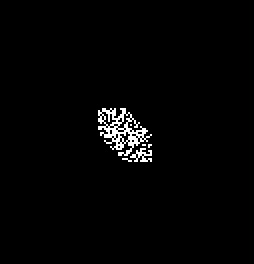

day24

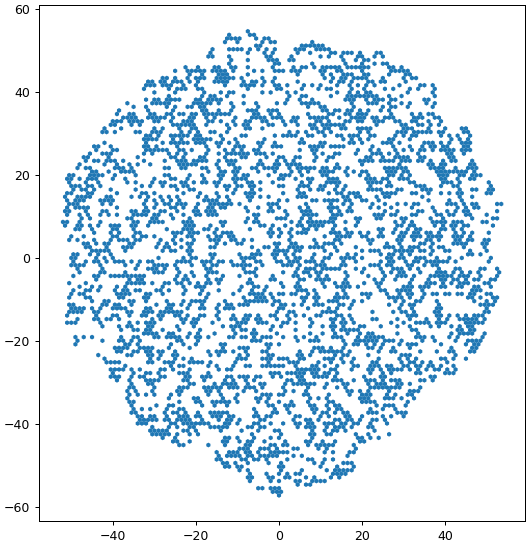

In [54]:
_ = day24_part2(puzzle.input, visualize=True)  # ~1700 ms.

<a name="day25"></a>
## Day 25: Public-key encryption

Given a card public key and a door public key, find the (private) card loop size and door loop size that were used to generate these public keys.  Then, find the common encryption key that the card and door use to communicate.

- Part 1: Report the encryption key.

- Part 2: There is no part 2 for this last day of the Advent.

In [128]:
puzzle = advent.puzzle(day=25)

For [day 25](https://adventofcode.com/2020/day/25), `puzzle.input` has 2 lines:

10212254
12577395


The stored answers are: `{1: '290487', 2: ''}`

In [129]:
s1 = """\
5764801
17807724
"""

In [130]:
def day25a(s, *, base=7, mod=20201227):  # Slow.
  card_public_key, door_public_key = map(int, s.splitlines())

  # Slow trial-multiplication; https://en.wikipedia.org/wiki/Discrete_logarithm
  def untransform(base, value):
    x = 1
    loop_size = 0
    while x != value:
      loop_size += 1
      x = (x * base) % mod
    return loop_size

  # Slow O(n) version.
  def transform(value, loop_size):
    x = 1
    for _ in range(loop_size):
      x = (x * value) % mod
    return x

  card_loop_size = untransform(base, card_public_key)
  door_loop_size = untransform(base, door_public_key)
  assert transform(base, card_loop_size) == card_public_key
  assert transform(base, door_loop_size) == door_public_key

  encryption_key1 = transform(door_public_key, card_loop_size)
  encryption_key2 = transform(card_public_key, door_loop_size)
  assert encryption_key1 == encryption_key2
  return encryption_key1


check_eq(day25a(s1), 14897079)
puzzle.verify(1, day25a)  # ~1000 ms.

(Part 1: 0.316 s)


In [131]:
def day25(s, *, base=7, mod=20201227):  # Fast.
  def pow_mod(base: int, exponent: int, mod: int) -> int:
    """Returns 'base**exponent % mod' using square-multiply algorithm."""
    x = 1
    while exponent > 0:
      if exponent % 2 == 1:
        x = (x * base) % mod
      base = (base * base) % mod
      exponent //= 2
    return x

  def log_mod(base: int, value: int, mod: int) -> int | None:
    """Returns exponent for 'base**exponent % mod == value'."""
    # Using https://en.wikipedia.org/wiki/Baby-step_giant-step
    # m = int(math.ceil(mod**0.5))
    m = math.isqrt(mod - 1) + 1
    table = {}
    e = 1
    for i in range(m):
      table[e] = i
      e = (e * base) % mod
    factor = pow_mod(base, mod - m - 1, mod)
    e = value
    for i in range(m):
      if e in table:
        return i * m + table[e]
      e = (e * factor) % mod
    return None

  card_public_key, door_public_key = map(int, s.splitlines())
  card_loop_size = log_mod(base, card_public_key, mod)
  assert card_loop_size is not None
  return pow_mod(door_public_key, card_loop_size, mod)


check_eq(day25(s1), 14897079)
puzzle.verify(1, day25)  # ~1 ms.

(Part 1: 0.000 s)


Part 2

In [132]:
puzzle.verify(2, lambda s: '')  # (No "Part 2" on last day.)
# (aocd does not allow a blank answer; the answer is not submitted)

(Part 2: 0.000 s)


<a name="timings"></a>
## Timings

In [133]:
advent.show_times()

day_1    part_1: 0.000   part_2: 0.001
day_2    part_1: 0.002   part_2: 0.001
day_3    part_1: 0.001   part_2: 0.001
day_4    part_1: 0.002   part_2: 0.002
day_5    part_1: 0.000   part_2: 0.001
day_6    part_1: 0.000   part_2: 0.001
day_7    part_1: 0.002   part_2: 0.002
day_8    part_1: 0.000   part_2: 0.004
day_9    part_1: 0.001   part_2: 0.001
day_10   part_1: 0.000   part_2: 0.000
day_11   part_1: 0.016   part_2: 0.039
day_12   part_1: 0.000   part_2: 0.000
day_13   part_1: 0.000   part_2: 0.000
day_14   part_1: 0.001   part_2: 0.010
day_15   part_1: 0.000   part_2: 0.375
day_16   part_1: 0.002   part_2: 0.021
day_17   part_1: 0.003   part_2: 0.057
day_18   part_1: 0.002   part_2: 0.002
day_19   part_1: 0.026   part_2: 0.118
day_20   part_1: 0.005   part_2: 0.013
day_21   part_1: 0.001   part_2: 0.000
day_22   part_1: 0.000   part_2: 0.407
day_23   part_1: 0.000   part_2: 0.177
day_24   part_1: 0.001   part_2: 0.149
day_25   part_1: 0.000   part_2: 0.000
Total time:  1.446 s


In [134]:
if 0:  # Compute min execution times over several calls.
  advent.show_times(recompute=True, repeat=3)

In [135]:
if 1:  # Look for unwanted pollution of namespace.
  print(
      textwrap.fill(
          ' '.join(
              name
              for name, value in globals().items()
              if not (name.startswith(('_', 'day')) or name in _ORIGINAL_GLOBALS)
          )
      )
  )

grid_from_string grid_from_indices puzzle s1 s2 s3 extended_gcd


In [136]:
if 0:  # Save puzzle inputs and answers to a compressed archive for downloading.
  # Create a new tar.gz file.
  hh.run(
      f"""cd /mnt/c/hh/tmp && cp -rp ~/.config/aocd/'{PROFILE.replace("_", " ")}' '{PROFILE}' && tar -czf '{PROFILE}.tar.gz' '{PROFILE}'"""
  )

In [138]:
if 0:  # Lint.
  hh.run('echo flake8; flake8')
  hh.run('echo mypy; mypy . || true')
  hh.run('echo autopep8; autopep8 -j8 -d .')
  hh.run('echo pylint; pylint -j8 . || true')
  print('All ran.')

In [139]:
hh.show_notebook_cell_top_times()

# Total time: 5.86 s
# In[ 87] # Faster, using np.array and numba.\n\n@numba.njit\ndef      1.037 s
# In[ 66] # More naive solution, but faster when using numba.\n\n@     0.788 s
# In[122] # Code keeping track of next cup label for each cup label:   0.566 s
# In[127] _ = day24_part2(puzzle.input, visualize=True)  # ~1700 ms.   0.452 s
# In[115] def day22_part2(s):  # Faster code using tuples.\n\n  # @    0.414 s
# In[130] def day25a(s, *, base=7, mod=20201227):  # Slow.\n  card_    0.322 s
# In[ 67] if hasattr(numba, 'jit'):\n  videos = {\n      'Part 1':     0.258 s
# In[126] def day24(s, *, part2=False, num_days=100, visualize=False)  0.233 s
# In[106] def day20(s, *, part2=False, visualize=False):\n  tiles = {  0.233 s
# In[102] def day19a(s, *, part2=False):  # Compact.\n  section1,      0.224 s
# In[103] def day19(s, *, part2=False):  # Faster.\n  section1,        0.148 s
# In[  9] try:\n  import numba\nexcept ModuleNotFoundError:\n  print(  0.115 s
# In[ 95] def day17(s, *, num_c

# End

In [140]:
# Goals:
# (1) Find puzzle answers.
# (2) Clean up code.
# (3) Speed up computation.
# (4) Visualize intermediate results.
# (5) Generalize to all puzzle inputs.

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->